# Laboratorium 5: Segmentacja polipów — Architektura typu U-Net(Kvasir-SEG)

W tym ćwiczeniu chcemy nauczyć się budowania i trenowania modeli **segmentacji semantycznej** z wykorzystaniem architektury **U-Net** oraz frameworka **PyTorch Lightning** na zbiorze danych medycznych **Kvasir-SEG** (segmentacja polipów jelitowych w obrazach endoskopowych).

**Główne zagadnienia:**
- Implementacja `LightningDataModule`: podział train/val/test, augmentacje spójne dla obrazu i maski.
- Budowa architektury **U-Net 2D** z enkoderem i dekoderem oraz skip connections.
- Funkcje straty dla segmentacji: **BCEWithLogitsLoss** i **Dice Loss**.
- Metryki: **Dice Score** i **IoU** (Intersection over Union) z biblioteki torchmetrics.
- Wykorzystanie **Transfer Learning** ResNet jako encoder w U-Net.

**Dataset:** 
Użyjemy **Kvasir-SEG** – zbioru zawierającego obrazy endoskopowe jelita grubego wraz z maskami segmentacji polipów. Dataset ten został stworzony do oceny algorytmów segmentacji w endoskopii i zawiera około 1000 par obraz-maska. Dane zostaną **automatycznie pobrane** w notebooku. Skalujemy je również do rozdzielczości 224x224 aby ograniczyć czas potrzebny na uczenie sieci.

## 0) Instalacja i importy

Jeśli chcemy powtarzalnych wyników możemy ustawić stały SEED.

In [1]:
# !pip -q install pytorch-lightning torchmetrics scikit-image opencv-python pillow --extra-index-url https://download.pytorch.org/whl/cpu

import os, zipfile, urllib.request, random, glob, math
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ssl

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

import torchvision.models as models
from torchvision.models import ResNet18_Weights


# SEED = 42
SEED = None
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

if SEED is not None:
    set_seed()
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device, '| Lightning:', pl.__version__)

Device: cuda | Lightning: 2.5.5


## 1) Pobranie i przygotowanie Kvasir-SEG

**Kvasir-SEG** to zbiór danych zawierający obrazy endoskopowe jelita grubego wraz z maskami segmentacji polipów. Poniższy fragment automatycznie pobiera zbiór i sprawdza liczbę pobranych plików. 

Należy zwrócić uwagę, że dla zadania segmentacji zarówno obrazy wejściowe jak i groundtruth są obrazami. W przypadku segmentacji binarnej (tło-obiekt) maska ma wartości binarne. Wymusza to delikatnie inne podejście do zarządzania i przetwarzania wstępnego takich danych.

In [2]:
DATA_ROOT = Path('./data/data_kvasir')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

ZIP_URL = 'https://datasets.simula.no/downloads/kvasir-seg.zip'
ZIP_PATH = DATA_ROOT / 'kvasir.zip'
EXTRACT_DIR = DATA_ROOT / 'Kvasir-SEG'

if not EXTRACT_DIR.exists():
    print('Pobieranie Kvasir-SEG (~150 MB)…')
    ssl._create_default_https_context = ssl._create_unverified_context
    urllib.request.urlretrieve(ZIP_URL, ZIP_PATH)
    print('Rozpakowywanie…')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_ROOT)
    print('Gotowe:', EXTRACT_DIR)
else:
    print('Dane już dostępne:', EXTRACT_DIR)

IMG_DIR = EXTRACT_DIR / 'images'
MSK_DIR = EXTRACT_DIR / 'masks'
imgs = sorted(glob.glob(str(IMG_DIR / '*.jpg')))
msks = sorted(glob.glob(str(MSK_DIR / '*.jpg')))
print('Liczba obrazów/masek:', len(imgs), len(msks))
assert len(imgs) == len(msks) and len(imgs) > 0, 'Brak danych lub brak par obraz–maska.'

Dane już dostępne: data/data_kvasir/Kvasir-SEG
Liczba obrazów/masek: 1000 1000


## Zadanie 1 – Dataset i DataModule dla segmentacji

W tym zadaniu zaimplementujesz własny Dataset oraz DataModule dla danych segmentacyjnych. Kluczową różnicą w porównaniu do klasyfikacji jest to, że augmentacje zmieniające pozycję obiektów (wszystkie przekształcenia geometryczne) muszą być stosowane zarówno do obrazu jak i maski – np. jeśli obracamy obraz o 10 stopni, to maskę również musimy obrócić o dokładnie ten sam kąt.

**Dataset dla segmentacji:**
1. Zaimplementuj klasę `KvasirDataset`, która dziedziczy po `Dataset`.
2. W metodzie `__init__` zapamiętaj ścieżki do obrazów (`img_paths`) i masek (`msk_paths`), oraz opcjonalny obiekt transform.
3. W metodzie `__len__` zwróć liczbę obrazów.
4. W metodzie `__getitem__`:
   - Wybierz odpowiednie ścieżki z zapamiętanych list podczas inicjalizacji.
   - Wczytaj obraz i maskę używając funkcji pomocniczej `load_pair`.
   - Jeśli `self.transform` istnieje, zastosuj go do obu (obraz, maska).
   - Zwróć parę (obraz, maska).

**Transform dla segmentacji:**
1. Zaimplementuj klasę `SegmentationTransform`, która będzie stosować te same transformacje do obrazu i maski. W przypadku segmentacji musimy sami ją zaimplementować, aby móć stosować spójną segmentację dla obu obrazów.
2. W metodzie `__init__`:
   - Zapamiętaj `size` (docelowy rozmiar obrazu).
   - Zapamiętaj `augment` (flaga czy stosować augmentacje, domyślnie False).
   - Stwórz obiekt do konwersji PIL do tensor: `transforms.ToTensor()`.
   - Stwórz **dwa** obiekty do resize: `transforms.Resize(size, ...)`. Pierwszy z interpolacją BILINEAR dla obrazu, a drugi z interpolacją NEAREST dla maski. Jest to ważne, gdyż maska jest binarna i nie chcemy rozmywać jej krawędzi.
   - Stwórz obiekt normalizacji: `transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])` – przesunie wartości z [0,1] do [-1,1].
3. W metodzie `__call__(self, img, mask)`:
   - Wykonaj resize dla obrazu i maski (na obrazach PIL).
   - Skonwertuj oba do tensorów (wartości [0, 1]).
   - Zbinaryzuj maskę: `mask = (mask > 0).float()` – chcemy, żeby maska zawiera tylko 0 i 1, ale miała typ zmiennoprzecinkowy.
   - Jeśli `self.augment == True`:
     - Z prawdopodobieństwem 50% wykonaj horizontal flip (dla obu).
     - Z prawdopodobieństwem 50% wykonaj losową rotację o kąt z przedziału [-10, 10] stopni. Zrób to samo dla obu obrazów, ale z różną interpolacją. Wykorzystaj `transforms.functional.rotate` i podaj argument `interpolation`.
   - Znormalizuj obraz (nie maskę) do [-1, 1].
   - Zwróć `(img.float(), mask.float())`.

**DataModule:**
1. Zaimplementuj klasę `KvasirDataModule`, która dziedziczy po `LightningDataModule`.
2. W metodzie `__init__`:
   - Zapamiętaj listy obrazów i masek.
   - Zapamiętaj `batch`, `nw` (num_workers), `train_split`, `val_split`, `img_size`.
   - Stwórz dwa obiekty transformacji: `self.train_transform` (z augment=True) i `self.val_test_transform` (z augment=False) jako obiekty zaimplementowanej wcześniej klasy.
3. W metodzie `setup(self, stage=None)`:
   - Wylosuj indeksy i podziel dane na train/val/test zgodnie z `train_split` i `val_split`. W tym celu stwórz listę indeksów od 0 do liczby próbek, a następnie wymieszaj je za pomocą `np.random.shuffle`. Podziel wynikowy wektor na 3 częsci zgodnie za przekazanym podziałem na część treningową, walidacyjną i testową. Następnie podziel również odpowiednio ścieżki do plików zgodnie z przygotowanymi listami indeksów.
   - Stwórz i zapamiętaj trzy datasety (treningowy, walidacyjny i testowy) z odpowiednimi transformacjami i zawierające próbki zgodnie w wcześniejszym losowaniem.
   - Wyświetl rozmiary zbiorów.
4. Zaimplementuj metody `train_dataloader()`, `val_dataloader()`, `test_dataloader()`:
   - Zwróć DataLoader z odpowiednim datastem.
   - Ustaw `shuffle=True` tylko dla train.
   - Ustaw `pin_memory=True` jeśli CUDA dostępne.

**Poza klasami:**
1. Stwórz instancję `KvasirDataModule` z listami `imgs` i `msks` (były stworzone we wcześniejszej komórce), rozmiarem batcha i liczbą workerów. Wartości te trzeba dobrać na podstawie specyfikacji maszyny na której uruchamiany będzie trening.
2. Wywołaj `dm.setup()`.
3. Pobierz jeden batch z train loadera (`next(iter(dm.train_dataloader()))`) i wyświetl kształty. Powinny pojawić się kształty typu `(16, 3, 384, 384)` dla obrazów i `(16, 1, 384, 384)` dla masek.

In [3]:
class KvasirDataset(Dataset):
    def __init__(self, img_paths, msk_paths, transform=None):
        self.img_paths = img_paths
        self.msk_paths = msk_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        msk_path = self.msk_paths[idx]
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(msk_path).convert('L')
        if self.transform:
            img, mask = self.transform(img, mask)
        else:
            to_tensor = transforms.ToTensor()
            img = to_tensor(img).float()
            mask = to_tensor(mask).float()
            mask = (mask > 0).float()
        
        return img, mask

class SegmentationTransform:
    def __init__(self, size=(384, 384), augment=False):
        self.size = size
        self.augment = augment
        self.to_tensor = transforms.ToTensor()
        self.img_resize = transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR)
        self.mask_resize = transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    def __call__(self, img, mask):
        img = self.img_resize(img)
        mask = self.mask_resize(mask)
        img = self.to_tensor(img)
        mask = self.to_tensor(mask)
        mask = (mask > 0).float()

        if self.augment:
            if random.random() > 0.5:
                img = transforms.functional.hflip(img)
                mask = transforms.functional.hflip(mask)
            
            if random.random() > 0.5:
                angle = random.uniform(-10, 10)
                img = transforms.functional.rotate(
                    img, angle, interpolation=transforms.InterpolationMode.BILINEAR
                )
                mask = transforms.functional.rotate(
                    mask, angle, interpolation=transforms.InterpolationMode.NEAREST
                )
        
        img = self.normalize(img)
        
        return img.float(), mask.float()

class KvasirDataModule(LightningDataModule):
    def __init__(self, img_paths, msk_paths, batch_size=16, num_workers=2, 
                 train_split=0.7, val_split=0.15, img_size=(384, 384)):
        super().__init__()
        self.img_paths = img_paths
        self.msk_paths = msk_paths
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_split = train_split
        self.val_split = val_split
        self.img_size = img_size
        
        self.train_transform = SegmentationTransform(size=img_size, augment=True)
        self.val_test_transform = SegmentationTransform(size=img_size, augment=False)
        
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
    
    def setup(self, stage=None):
        n_samples = len(self.img_paths)
        indices = list(range(n_samples))
        
        np.random.shuffle(indices)

        train_end = int(self.train_split * n_samples)
        val_end = train_end + int(self.val_split * n_samples)

        train_indices = indices[:train_end]
        val_indices = indices[train_end:val_end]
        test_indices = indices[val_end:]

        train_imgs = [self.img_paths[i] for i in train_indices]
        train_msks = [self.msk_paths[i] for i in train_indices]
        
        val_imgs = [self.img_paths[i] for i in val_indices]
        val_msks = [self.msk_paths[i] for i in val_indices]
        
        test_imgs = [self.img_paths[i] for i in test_indices]
        test_msks = [self.msk_paths[i] for i in test_indices]
        
        self.train_dataset = KvasirDataset(train_imgs, train_msks, self.train_transform)
        self.val_dataset = KvasirDataset(val_imgs, val_msks, self.val_test_transform)
        self.test_dataset = KvasirDataset(test_imgs, test_msks, self.val_test_transform)
        
        print(f"Rozmiary zbiorów: Train: {len(self.train_dataset)}, "
              f"Val: {len(self.val_dataset)}, Test: {len(self.test_dataset)}")
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available()
        )


dm = KvasirDataModule(
    img_paths=imgs,
    msk_paths=msks,
    batch_size=16,
    num_workers=2,
    train_split=0.7,
    val_split=0.15,
    img_size=(384, 384)
)

dm.setup()

train_loader = dm.train_dataloader()
batch_imgs, batch_masks = next(iter(train_loader))

print(f"Kształt obrazów: {batch_imgs.shape}")
print(f"Kształt masek: {batch_masks.shape}")
print(f"Zakres wartości obrazów: [{batch_imgs.min():.3f}, {batch_imgs.max():.3f}]")
print(f"Unikalne wartości w maskach: {torch.unique(batch_masks)}")

Rozmiary zbiorów: Train: 700, Val: 150, Test: 150
Kształt obrazów: torch.Size([16, 3, 384, 384])
Kształt masek: torch.Size([16, 1, 384, 384])
Zakres wartości obrazów: [-1.000, 1.000]
Unikalne wartości w maskach: tensor([0., 1.])


## Zadanie 2 – Implementacja U-Net: architektura enkodera i dekodera

W tym zadaniu zaimplementujesz architekturę **U-Net** – jedną z najpopularniejszych sieci do segmentacji medycznej. U-Net składa się z:
- **Enkodera** (downsampling path): ekstraktuje cechy wysokiego poziomu, zmniejszając rozdzielczość.
- **Dekodera** (upsampling path): odbudowuje rozdzielczość, tworząc maskę segmentacji.
- **Skip connections**: połączenia z enkodera do dekodera na tym samym poziomie rozdzielczości – pozwalają zachować szczegóły przestrzenne.

![U-Net architecture diagram](https://iq.opengenus.org/content/images/2021/12/1_ovEGmOI3bcCeauu8jEBzsg.png)

**Blok DoubleConv:**
1. Zaimplementuj klasę `DoubleConv`, która dziedziczy po `nn.Module`.
2. Przyjmuje parametry: `in_ch` (kanały wejściowe), `out_ch` (kanały wyjściowe), `dropout` (prawdopodobieństwo dropout, domyślnie 0.0).
Dropout to technika regularyzacji, która losowo "wyłącza" pewien procent neuronów podczas treningu. Zmusza to sieć do uczenia się bardziej uniwersalnych i odpornych reprezentacji, ponieważ nie może polegać na pojedynczych neuronach/kanałach. Będziemy wykorzystywać `Dropout2d`, który usuwa całe kanały w warstwach konwolucyjnych. Warstwy te pozwalają ograniczyć zjawisko przeuczenia (overfitting).
3. Zbuduj sekwencję warstw:
   - `Conv2d(in_ch, out_ch, kernel_size=3, padding=1)` – konwolucja bez zmiany rozmiaru.
   - `BatchNorm2d(out_ch)` – normalizacja batch.
   - `ReLU(inplace=True)` – aktywacja.
   - Opcjonalnie: `Dropout2d(p=dropout)` jeśli dropout > 0.
   - Powtórz: `Conv2d(out_ch, out_ch, 3, padding=1)`, `BatchNorm2d`, `ReLU`. Ewentualnie może tutaj również nastąpić zmiana liczby kanałów wyjściowych. Wtedy na wejściu podczas inicjalizacji musimy przekazać dodatkowy parametr.
   - Opcjonalnie: ponownie `Dropout2d(p=dropout)` jeśli dropout > 0.
4. W metodzie `forward(x)` przepuść dane przez zbudowaną sekwencję.

**Model UNetSmall:**
1. Zaimplementuj klasę `UNetSmall`, która dziedziczy po `nn.Module`.
2. W `__init__` przyjmij: `in_ch1=3` (RGB), `out_ch=1` (maska binarna), `dropout=0.0`.
3. **Encoder (ścieżka downsampling):**
   - `DoubleConv(in_ch1, out_ch1, dropout)` – pierwszy blok (d1).
   - `nn.MaxPool2d(2)` – pooling 2×2 (zmniejsza rozdzielczość o połowę) (p1).
   - `DoubleConv(out_ch1, out_ch2, dropout)` – drugi blok (d2).
   - `nn.MaxPool2d(2)` (p2).
   - `DoubleConv(out_ch2, out_ch3, dropout)` – trzeci blok (d3).
   - `nn.MaxPool2d(2)` (p3).
4. **Bottleneck (najgłębsza część):**
   - `DoubleConv(out_ch3, out_ch4, dropout)` – ewentualnie w tej warstwie można zwiększyć dropout względem innych warstw (b).
5. **Decoder (ścieżka upsampling):**
   - `nn.ConvTranspose2d(out_ch4, out_ch3, kernel_size=2, stride=2)` – upsampling (zwiększa rozdzielczość 2×) (u3).
   - `DoubleConv(2*out_ch3, out_ch3, dropout)` – uwaga: 2*out_ch3 = out_ch3 (z poprzedniej warstwy) + out_ch3 (skip connection z enkodera) (c3).
   - `nn.ConvTranspose2d(out_ch3, out_ch2, 2, 2)` (u2).
   - `DoubleConv(2*out_ch2, out_ch2, dropout)` (c2).
   - `nn.ConvTranspose2d(out_ch2, out_ch1, 2, 2)` (u1).
   - `DoubleConv(2*out_ch1, out_ch1, dropout)` (c1).
6. **Warstwa wyjściowa:**
   - `nn.Conv2d(out_ch1, out_ch, kernel_size=1)` – konwolucja 1×1, zwraca logity (out).
7. W metodzie `forward(x)`:
   - **Encoder:** przepuść wejście przez `d1→p1→d2→p2→d3→p3→b`, zapamiętuj wyjścia z d1, d2 i d3, bo są potrzebne do skip connections.
   - **Decoder:**
     - Przepuść wyjście z bottleneck przez u3, potem skonkatenuj ze skip connection z d3 `torch.cat([u3, d3], dim=1)`, a następnie przepuść przez c3.
     - Zrób do samo wykorzystując warstwy u2 i c2 oraz wyjście z d2.
     - Zrób do samo wykorzystując warstwy u1 i c1 oraz wyjście z d1.
   - Na koniec przepuść dane przez warstwę wyjściową out.

**Dice Loss:**
1. Zaimplementuj klasę `DiceLoss`, dziedziczącą po `nn.Module`.
2. W `__init__(self, eps=1e-6)` zapamiętaj `eps=1e-6` (wartość dodawana dla stabilności numerycznej).
3. DiceLoss pochodzi od współczynnika Dice (Dice coefficient, F1 dla segmentacji), który mierzy nakładanie się dwóch masek: `Dice = 2 * |P ∩ G| / (|P| + |G|)`, gdzie `P` to predykcja, `G` to maska, natomiast operator | | oznacza liczność zbioru. Zakres wartości to [0, 1], im większe — tym lepsze dopasowanie. `DiceLoss` wynosi `1 − Dice` (dla zadanie minimalizacji). Dodajemy małą wartość eps dla stabilności numerycznej do licznika i mianownika. Skupia się on na nakładaniu się obszarów, a nie na pojedynczych pikselach, co daje lepszą jakość predykcji maski.
4. W `forward(self, logits, targets)`:
   - Zastosuj sigmoid do logitów: `torch.sigmoid(logits)`.
   - Upewnij się że targets są typu float.
   - Oblicz licznik. W tym celu pomnóż wyniki sigmoidy z `targets`, a następnie zsumuj po wymiarach przestrzennych, pomnóż przez 2 i dodał `eps`.
   - Oblicz mianownik symetrycznie do licznika, zgodnie z wzorem.
   - Podziel otrzymane wartości, oblicz wartość średnią po wszystkich wymiarach (batch) i odejmij wynik od 1. Zwróć obliczoną wielkość.

**Callbacks i Lightning Module:**
1. Kod zawiera już gotową implementację `MetricsCallback` (do zbierania metryk).
2. Konieczna jest jeszcze implementacja `LitUNet` (Lightning wrapper dla zaprejektowanej sieci z optymalizatorem, stratami i metrykami), która dziedziczy po `LightningModule`. Implementacja jest podobna do poprzedniego ćwiczenia.
3. W metodzie `__init__(self, in_ch=3, lr=1e-3, dropout=0.0)`:
   - Wywołaj `super().__init__()`.
   - Zapisz hiperparametry: `self.save_hyperparameters()` – Lightning automatycznie zapisze je w checkpointach.
   - Stwórz instancję stworzonej wcześniej sieci.
   - Zdefiniuj i zapamiętaj funkcje straty:
     - `nn.BCEWithLogitsLoss()` – Binary Cross-Entropy (działa na logitach, wewnętrznie aplikuje sigmoid).
     - `DiceLoss()` – nasza implementacja Dice Loss.
   - Zdefiniuj metryki (z torchmetrics):
     - `BinaryJaccardIndex()` – IoU (Intersection over Union).
     - `BinaryF1Score()` – F1/Dice Score. Odpowiednik zaimplementowanej fukncji straty, ale używa progowania prawdopodobieństwa, przez co nie można dla niej obliczyć gradientu.
4. W metodzie `forward(self, x)`:
   - Przepuść wejście przez sieć.
5. W metodzie `configure_optimizers(self)`:
   - Wykorzystaj optymalizator `Adam`.
   - Wykorzystaj scheduler `CosineAnnealingLR`.
   - Zwróć słownik zawierający optymalizator i scheduler.
6. Zdefiniuj metody `training_step`, `validation_step` i `test_step`. Prawie wszystkie operacje są w nich takie sameg więc można je przenieść do funkcji pomocniczej.
   - Rozpakuj batch (obrazy i maski).
   - Oblicz wyjście sieci `self(x)`.
   - Oblicz stratę jako sumę BCEWithLogitsLoss + DiceLoss
   - Oblicz metryki do monitoringu w bloku `with torch.no_grad():`:
     - Wykonaj progowanie predykcji sieci, aby wyznaczyć wynik segmentacji.
     - Upewnij się że zarówno maska groundtruth i wynik predykcji są typu `int`.
     - Oblicz IoU i F1(Dice) za pomocą stworzonych podczas inicjalizacji obiektów.
   - Zaloguj metryki za pomocą funkcji `self.log()`:
     - Pierwszym argumentem jest nazwa logowanej metryki.
     - Drugim argumentem jest jej wartość.
     - Flaga `on_epoch` sprawia, że metryka jest agregowana i logowana dla całej epoki. Ustaw ją jako `True`.
     - Flaga `prog_bar` mówi czy wartość tej metryki ma być wyświetlona obok paska postępu.
   - Zwróć `loss` dla `training_step`.

In [4]:
class MetricsCallback(pl.Callback):
    """Callback to collect training metrics for visualization"""
    def __init__(self):
        super().__init__()
        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'train_iou': [],
            'val_iou': [],
            'epoch': []
        }
    
    def on_train_epoch_end(self, trainer, pl_module):
        # Collect training metrics
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch + 1
        
        self.metrics['epoch'].append(epoch)
        self.metrics['train_loss'].append(metrics.get('train_loss_epoch', float('nan')).item())
        self.metrics['train_dice'].append(metrics.get('train_dice_epoch', float('nan')).item())
        self.metrics['train_iou'].append(metrics.get('train_iou_epoch', float('nan')).item())
    
    def on_validation_epoch_end(self, trainer, pl_module):
        # Collect validation metrics
        metrics = trainer.callback_metrics
        
        # Only add validation metrics if we have them
        if 'val_loss' in metrics:
            self.metrics['val_loss'].append(metrics['val_loss'].item())
            self.metrics['val_dice'].append(metrics['val_dice'].item())
            self.metrics['val_iou'].append(metrics['val_iou'].item())


In [5]:
# Blok DoubleConv
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ]
        
        if dropout > 0:
            layers.append(nn.Dropout2d(p=dropout))
            
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ])
        
        if dropout > 0:
            layers.append(nn.Dropout2d(p=dropout))
            
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv(x)

# Model UNetSmall
class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, dropout=0.0):
        super().__init__()
        out_ch1 = 64
        out_ch2 = 128
        out_ch3 = 256
        out_ch4 = 512
        
        # Encoder
        self.d1 = DoubleConv(in_ch, out_ch1, dropout)
        self.p1 = nn.MaxPool2d(2)
        
        self.d2 = DoubleConv(out_ch1, out_ch2, dropout)
        self.p2 = nn.MaxPool2d(2)
        
        self.d3 = DoubleConv(out_ch2, out_ch3, dropout)
        self.p3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.b = DoubleConv(out_ch3, out_ch4, dropout)
        
        # Decoder
        self.u3 = nn.ConvTranspose2d(out_ch4, out_ch3, kernel_size=2, stride=2)
        self.c3 = DoubleConv(2 * out_ch3, out_ch3, dropout)
        
        self.u2 = nn.ConvTranspose2d(out_ch3, out_ch2, kernel_size=2, stride=2)
        self.c2 = DoubleConv(2 * out_ch2, out_ch2, dropout)
        
        self.u1 = nn.ConvTranspose2d(out_ch2, out_ch1, kernel_size=2, stride=2)
        self.c1 = DoubleConv(2 * out_ch1, out_ch1, dropout)
        
        # Output
        self.out = nn.Conv2d(out_ch1, out_ch, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        d1_out = self.d1(x)
        p1_out = self.p1(d1_out)
        
        d2_out = self.d2(p1_out)
        p2_out = self.p2(d2_out)
        
        d3_out = self.d3(p2_out)
        p3_out = self.p3(d3_out)
        
        # Bottleneck
        b_out = self.b(p3_out)
        
        # Decoder
        u3_out = self.u3(b_out)
        c3_in = torch.cat([u3_out, d3_out], dim=1)
        c3_out = self.c3(c3_in)
        
        u2_out = self.u2(c3_out)
        c2_in = torch.cat([u2_out, d2_out], dim=1)
        c2_out = self.c2(c2_in)
        
        u1_out = self.u1(c2_out)
        c1_in = torch.cat([u1_out, d1_out], dim=1)
        c1_out = self.c1(c1_in)
        
        # Output
        out = self.out(c1_out)
        
        return out

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        targets = targets.float()
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)
        intersection = 2 * (probs_flat * targets_flat).sum(dim=1)
        union = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)
        dice = (intersection + self.eps) / (union + self.eps)
        
        return 1 - dice.mean()

# Lightning Module dla U-Net
# Lightning Module dla U-Net - POPRAWIONA WERSJA
class LitUNet(LightningModule):
    def __init__(self, in_ch=3, lr=1e-3, dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = UNetSmall(in_ch=in_ch, out_ch=1, dropout=dropout)
        
        # Funkcje straty
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()
        
        # Metryki - używamy _epoch do agregacji
        self.train_iou = BinaryJaccardIndex()
        self.val_iou = BinaryJaccardIndex()
        self.test_iou = BinaryJaccardIndex()
        
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()
        
        self.lr = lr
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }
    
    def _shared_step(self, batch, batch_idx, prefix):
        x, y_true = batch
        
        # Predykcja
        y_pred = self(x)
        
        # Obliczanie strat
        bce_loss = self.bce_loss(y_pred, y_true)
        dice_loss = self.dice_loss(y_pred, y_true)
        total_loss = bce_loss + dice_loss
        
        # Obliczanie metryk
        with torch.no_grad():
            y_pred_bin = (torch.sigmoid(y_pred) > 0.5).float()
            y_true_int = y_true.int()
            y_pred_int = y_pred_bin.int()
            
            if prefix == 'train':
                iou = self.train_iou(y_pred_int, y_true_int)
                f1 = self.train_f1(y_pred_int, y_true_int)
            elif prefix == 'val':
                iou = self.val_iou(y_pred_int, y_true_int)
                f1 = self.val_f1(y_pred_int, y_true_int)
            else:  # test
                iou = self.test_iou(y_pred_int, y_true_int)
                f1 = self.test_f1(y_pred_int, y_true_int)
        
        # Logowanie - POPRAWIONE dla zgodności z MetricsCallback
        self.log(f'{prefix}_loss', total_loss, on_epoch=True, prog_bar=True)
        self.log(f'{prefix}_loss_epoch', total_loss, on_epoch=True, prog_bar=False)
        self.log(f'{prefix}_bce_loss', bce_loss, on_epoch=True)
        self.log(f'{prefix}_dice_loss', dice_loss, on_epoch=True)
        
        # Logowanie F1 jako dice dla zgodności z MetricsCallback
        self.log(f'{prefix}_dice', f1, on_epoch=True, prog_bar=True)
        self.log(f'{prefix}_dice_epoch', f1, on_epoch=True, prog_bar=False)
        
        # Logowanie IoU
        self.log(f'{prefix}_iou', iou, on_epoch=True, prog_bar=True)
        self.log(f'{prefix}_iou_epoch', iou, on_epoch=True, prog_bar=False)
        
        return total_loss
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'val')
    
    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'test')


    
# test
batch_size = 2
x_test = torch.randn(batch_size, 3, 384, 384)
y_test = torch.rand(batch_size, 1, 384, 384)
y_test = (y_test > 0.5).float()

print(f"Unikalne wartości w y_test: {torch.unique(y_test)}")

# Test modelu
model = UNetSmall(in_ch=3, out_ch=1, dropout=0.1)
y_pred = model(x_test)
print(f"Input shape: {x_test.shape}")
print(f"Output shape: {y_pred.shape}")

# Test funkcji straty
dice_loss = DiceLoss()
loss_value = dice_loss(y_pred, y_test)
print(f"Dice loss: {loss_value:.4f}")

# Test Lightning Module
lit_model = LitUNet(in_ch=3, lr=1e-3, dropout=0.1)

# Test optymalizatora
optimizer = lit_model.configure_optimizers()
print("Optymalizator i scheduler skonfigurowane poprawnie")

# Test pojedynczego kroku treningowego
with torch.no_grad():
    loss = lit_model.training_step((x_test, y_test), 0)
    print(f"Training step loss: {loss:.4f}")

# Test MetricsCallback
metrics_callback = MetricsCallback()
print("MetricsCallback zainicjalizowany poprawnie")

print("Wszystkie testy zakończone pomyślnie!")

Unikalne wartości w y_test: tensor([0., 1.])
Input shape: torch.Size([2, 3, 384, 384])
Output shape: torch.Size([2, 1, 384, 384])
Dice loss: 0.5170
Optymalizator i scheduler skonfigurowane poprawnie
Training step loss: 1.1881
MetricsCallback zainicjalizowany poprawnie
Wszystkie testy zakończone pomyślnie!


/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/pytorch_lightning/core/module.py:449: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


## Zadanie 3 – Trening U-Net: callbacks, wizualizacja metryk i ewaluacja

Teraz chcemy wytrenować stworzoną architekturę sieci do segmentacji.

1. Stworzenie modelu i callbacków:
   - Utwórz instancję klasy sieci.
   - Utwórz obiekty `MetricsCallback` – będzie zbierać metryki do wizualizacji.
   - Utwórz `EarlyStopping` – ma zatrzymać trening jeśli metryka F1/Dice na zbiorze walidacyjnym nie rośnie przez określoną liczbę epok.
   - Utwórz `ModelCheckpoint` – ma zapisywać najlepszy model pod względem metryki F1/Dice dla zbioru walidacyjnego.

2. **Trening:**
   - Stwórz `Trainer(max_epochs=50, accelerator='auto', devices=1, callbacks=[metrics_callback, early, ckpt], precision=16)`. Określ maksymalną liczbę epok, ustaw `accelerator` jako `'auto'`, przekaż callbacki w `callbacks`. Możesz również sprawdzić jak precyzja numeryczna wpływa na szybkość i wyniki uczenia. Jest ona przekazywana przez argument `precision`. Porównaj wartość 32 i 16 (stosowanie Automatic Mixed Precision).
   - Wykonaj trening sieci `trainer.fit`.

3. **Wizualizacja przebiegu treningu:**
   - Wyciągnij zebrane metryki z `metrics_callback.metrics`. Jest to słownik zawierający nazwy pól jak w wywołaniach metod `self.log` sieci.
   - Stwórz 3 wykresy:
     -  Train Loss i Val Loss w funkcji epok.
     -  Train Dice i Val F1/Dice w funkcji epok.
     -  Train IoU i Val IoU w funkcji epok.

4. **Test na zbiorze testowym:**
   - Wczytaj najlepszy model.
   - Sprawdź metryki na zbiorze testowym za pomocą metody `test`.

5. **Wizualizacja predykcji:**
   - Przełącz model w tryb ewaluacji.
   - Pobierz jeden batch z test loadera: `xb, yb = next(iter(dm.test_dataloader()))`.
   - Oblicz predykcje dla pobranego batcha wewnątrz bloku `torch.no_grad():`. Dodatkowo obliczone logity przepuść przez sigmoidę, aby otrzymać wartości prawdopodobieństwa.
   - Zbinaryzuj predykcje.
   - Dla kilku pierwszych przykładów wyświetl w rzędzie:
     - Kolumna 1: Oryginalny obraz: `((xb[i].permute(1,2,0).numpy()*0.5)+0.5).clip(0,1)`.
     - Kolumna 2: Maska GT: `yb[i,0]`.
     - Kolumna 3: Predykcja: `preds[i,0]`.
     - Kolumna 4: Obraz oryginalny z nałożoną predykcją (zmień kolor pikseli na czerwony):
     `overlay = img.copy(); m = preds[i,0].numpy()>0.5; overlay[m] = [1.0, 0.0, 0.0]`

In [6]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [7]:
# Zadanie 3 – Trening U-Net: callbacks, wizualizacja metryk i ewaluacja

print("=== U-NET TRAINING ===")

print("\n1. Initializing model and callacks...")

dm = KvasirDataModule(
    img_paths=imgs,
    msk_paths=msks,
    batch_size=4,
    num_workers=2,
    train_split=0.7,
    val_split=0.15,
    img_size=(384, 384)
)

model = LitUNet(in_ch=3, lr=1e-3, dropout=0.2)

metrics_callback = MetricsCallback()

early_stopping = EarlyStopping(
    monitor='val_dice',
    mode='max',
    patience=10,
    verbose=True
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_dice',  # Changed from 'val_f1' to 'val_dice'
    mode='max',
    save_top_k=1,
    save_last=True,
    filename='unet-best-{epoch:02d}-{val_dice:.3f}',  # Also updated filename
    verbose=True
)

print("Created model and callbacks.")

trainer = Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[metrics_callback, early_stopping, checkpoint_callback],
    precision=16,
    log_every_n_steps=10,
    val_check_interval=0.5
)

print("Training...")
trainer.fit(model, dm)

print("Training finished.")


/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/karolina/studia/piaom/venv/lib/python3.12/site-packages/torch/_

=== U-NET TRAINING ===

1. Initializing model and callacks...
Created model and callbacks.
Training...
Rozmiary zbiorów: Train: 700, Val: 150, Test: 150
Epoch 0:  50%|████▉     | 87/175 [00:14<00:14,  5.87it/s, v_num=2, train_loss_step=1.010, train_dice_step=0.513, train_iou_step=0.345]  

Metric val_dice improved. New best score: 0.396


Epoch 0:  50%|████▉     | 87/175 [00:17<00:17,  5.11it/s, v_num=2, train_loss_step=1.010, train_dice_step=0.513, train_iou_step=0.345, val_loss=1.130, val_dice=0.396, val_iou=0.255]

Epoch 0, global step 87: 'val_dice' reached 0.39599 (best 0.39599), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=00-val_dice=0.396.ckpt' as top 1


Epoch 0:  99%|█████████▉| 174/175 [00:31<00:00,  5.45it/s, v_num=2, train_loss_step=1.170, train_dice_step=0.363, train_iou_step=0.222, val_loss=1.130, val_dice=0.396, val_iou=0.255]    

Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.400


Epoch 0:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=1.170, train_dice_step=0.363, train_iou_step=0.222, val_loss=1.130, val_dice=0.400, val_iou=0.258]

Epoch 0, global step 174: 'val_dice' reached 0.39991 (best 0.39991), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=00-val_dice=0.400.ckpt' as top 1


Epoch 1:  50%|████▉     | 87/175 [00:14<00:14,  5.89it/s, v_num=2, train_loss_step=0.981, train_dice_step=0.473, train_iou_step=0.309, val_loss=1.130, val_dice=0.400, val_iou=0.258, train_loss_epoch=1.140, train_dice_epoch=0.384, train_iou_epoch=0.247] 

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.402


Epoch 1:  50%|████▉     | 87/175 [00:16<00:17,  5.12it/s, v_num=2, train_loss_step=0.981, train_dice_step=0.473, train_iou_step=0.309, val_loss=1.130, val_dice=0.402, val_iou=0.259, train_loss_epoch=1.140, train_dice_epoch=0.384, train_iou_epoch=0.247]

Epoch 1, global step 262: 'val_dice' reached 0.40181 (best 0.40181), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=01-val_dice=0.402.ckpt' as top 1


Epoch 1:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=0.919, train_dice_step=0.639, train_iou_step=0.470, val_loss=1.130, val_dice=0.392, val_iou=0.250, train_loss_epoch=1.140, train_dice_epoch=0.384, train_iou_epoch=0.247]  

Epoch 1, global step 349: 'val_dice' was not in top 1


Epoch 2:  50%|████▉     | 87/175 [00:16<00:17,  5.12it/s, v_num=2, train_loss_step=1.100, train_dice_step=0.426, train_iou_step=0.271, val_loss=1.110, val_dice=0.374, val_iou=0.238, train_loss_epoch=1.090, train_dice_epoch=0.399, train_iou_epoch=0.259] 

Epoch 2, global step 437: 'val_dice' was not in top 1


Epoch 2:  99%|█████████▉| 174/175 [00:34<00:00,  5.11it/s, v_num=2, train_loss_step=1.030, train_dice_step=0.434, train_iou_step=0.277, val_loss=1.120, val_dice=0.401, val_iou=0.259, train_loss_epoch=1.090, train_dice_epoch=0.399, train_iou_epoch=0.259] 

Epoch 2, global step 524: 'val_dice' was not in top 1


Epoch 3:  50%|████▉     | 87/175 [00:16<00:17,  5.12it/s, v_num=2, train_loss_step=1.050, train_dice_step=0.425, train_iou_step=0.270, val_loss=1.100, val_dice=0.400, val_iou=0.258, train_loss_epoch=1.080, train_dice_epoch=0.389, train_iou_epoch=0.249] 

Epoch 3, global step 612: 'val_dice' was not in top 1


Epoch 3:  99%|█████████▉| 174/175 [00:34<00:00,  5.11it/s, v_num=2, train_loss_step=1.030, train_dice_step=0.461, train_iou_step=0.299, val_loss=1.100, val_dice=0.381, val_iou=0.243, train_loss_epoch=1.080, train_dice_epoch=0.389, train_iou_epoch=0.249]  

Epoch 3, global step 699: 'val_dice' was not in top 1


Epoch 4:  50%|████▉     | 87/175 [00:16<00:17,  5.12it/s, v_num=2, train_loss_step=1.070, train_dice_step=0.499, train_iou_step=0.332, val_loss=1.100, val_dice=0.397, val_iou=0.256, train_loss_epoch=1.080, train_dice_epoch=0.401, train_iou_epoch=0.261] 

Epoch 4, global step 787: 'val_dice' was not in top 1


Epoch 4:  99%|█████████▉| 174/175 [00:31<00:00,  5.47it/s, v_num=2, train_loss_step=1.140, train_dice_step=0.275, train_iou_step=0.159, val_loss=1.100, val_dice=0.397, val_iou=0.256, train_loss_epoch=1.080, train_dice_epoch=0.401, train_iou_epoch=0.261] 

Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.405


Epoch 4:  99%|█████████▉| 174/175 [00:34<00:00,  5.11it/s, v_num=2, train_loss_step=1.140, train_dice_step=0.275, train_iou_step=0.159, val_loss=1.100, val_dice=0.405, val_iou=0.261, train_loss_epoch=1.080, train_dice_epoch=0.401, train_iou_epoch=0.261]

Epoch 4, global step 874: 'val_dice' reached 0.40483 (best 0.40483), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=04-val_dice=0.405.ckpt' as top 1


Epoch 5:  50%|████▉     | 87/175 [00:16<00:17,  5.12it/s, v_num=2, train_loss_step=1.110, train_dice_step=0.279, train_iou_step=0.162, val_loss=1.080, val_dice=0.369, val_iou=0.236, train_loss_epoch=1.070, train_dice_epoch=0.409, train_iou_epoch=0.266]  

Epoch 5, global step 962: 'val_dice' was not in top 1


Epoch 5:  99%|█████████▉| 174/175 [00:31<00:00,  5.47it/s, v_num=2, train_loss_step=1.160, train_dice_step=0.180, train_iou_step=0.0989, val_loss=1.080, val_dice=0.369, val_iou=0.236, train_loss_epoch=1.070, train_dice_epoch=0.409, train_iou_epoch=0.266]

Metric val_dice improved by 0.020 >= min_delta = 0.0. New best score: 0.425


Epoch 5:  99%|█████████▉| 174/175 [00:34<00:00,  5.11it/s, v_num=2, train_loss_step=1.160, train_dice_step=0.180, train_iou_step=0.0989, val_loss=1.080, val_dice=0.425, val_iou=0.277, train_loss_epoch=1.070, train_dice_epoch=0.409, train_iou_epoch=0.266]

Epoch 5, global step 1049: 'val_dice' reached 0.42514 (best 0.42514), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=05-val_dice=0.425.ckpt' as top 1


Epoch 6:  50%|████▉     | 87/175 [00:14<00:14,  5.89it/s, v_num=2, train_loss_step=1.080, train_dice_step=0.508, train_iou_step=0.341, val_loss=1.080, val_dice=0.425, val_iou=0.277, train_loss_epoch=1.050, train_dice_epoch=0.429, train_iou_epoch=0.283]  

Metric val_dice improved by 0.014 >= min_delta = 0.0. New best score: 0.440


Epoch 6:  50%|████▉     | 87/175 [00:17<00:17,  5.12it/s, v_num=2, train_loss_step=1.080, train_dice_step=0.508, train_iou_step=0.341, val_loss=1.050, val_dice=0.440, val_iou=0.289, train_loss_epoch=1.050, train_dice_epoch=0.429, train_iou_epoch=0.283]

Epoch 6, global step 1137: 'val_dice' reached 0.43955 (best 0.43955), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=06-val_dice=0.440.ckpt' as top 1


Epoch 6:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=0.925, train_dice_step=0.522, train_iou_step=0.353, val_loss=1.040, val_dice=0.439, val_iou=0.290, train_loss_epoch=1.050, train_dice_epoch=0.429, train_iou_epoch=0.283] 

Epoch 6, global step 1224: 'val_dice' was not in top 1


Epoch 7:  50%|████▉     | 87/175 [00:14<00:14,  5.89it/s, v_num=2, train_loss_step=1.130, train_dice_step=0.215, train_iou_step=0.120, val_loss=1.040, val_dice=0.439, val_iou=0.290, train_loss_epoch=1.030, train_dice_epoch=0.446, train_iou_epoch=0.296] 

Metric val_dice improved by 0.014 >= min_delta = 0.0. New best score: 0.453


Epoch 7:  50%|████▉     | 87/175 [00:16<00:17,  5.12it/s, v_num=2, train_loss_step=1.130, train_dice_step=0.215, train_iou_step=0.120, val_loss=1.020, val_dice=0.453, val_iou=0.301, train_loss_epoch=1.030, train_dice_epoch=0.446, train_iou_epoch=0.296]

Epoch 7, global step 1312: 'val_dice' reached 0.45314 (best 0.45314), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=07-val_dice=0.453.ckpt' as top 1


Epoch 7:  99%|█████████▉| 174/175 [00:31<00:00,  5.44it/s, v_num=2, train_loss_step=1.400, train_dice_step=0.347, train_iou_step=0.210, val_loss=1.020, val_dice=0.453, val_iou=0.301, train_loss_epoch=1.030, train_dice_epoch=0.446, train_iou_epoch=0.296]

Metric val_dice improved by 0.007 >= min_delta = 0.0. New best score: 0.460


Epoch 7:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=1.400, train_dice_step=0.347, train_iou_step=0.210, val_loss=1.030, val_dice=0.460, val_iou=0.309, train_loss_epoch=1.030, train_dice_epoch=0.446, train_iou_epoch=0.296]

Epoch 7, global step 1399: 'val_dice' reached 0.46049 (best 0.46049), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=07-val_dice=0.460.ckpt' as top 1


Epoch 8:  50%|████▉     | 87/175 [00:14<00:14,  5.87it/s, v_num=2, train_loss_step=0.993, train_dice_step=0.505, train_iou_step=0.338, val_loss=1.030, val_dice=0.460, val_iou=0.309, train_loss_epoch=1.020, train_dice_epoch=0.469, train_iou_epoch=0.315] 

Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.464


Epoch 8:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=0.993, train_dice_step=0.505, train_iou_step=0.338, val_loss=1.020, val_dice=0.464, val_iou=0.313, train_loss_epoch=1.020, train_dice_epoch=0.469, train_iou_epoch=0.315]

Epoch 8, global step 1487: 'val_dice' reached 0.46408 (best 0.46408), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=08-val_dice=0.464.ckpt' as top 1


Epoch 8:  99%|█████████▉| 174/175 [00:34<00:00,  5.07it/s, v_num=2, train_loss_step=1.040, train_dice_step=0.503, train_iou_step=0.336, val_loss=1.030, val_dice=0.457, val_iou=0.305, train_loss_epoch=1.020, train_dice_epoch=0.469, train_iou_epoch=0.315] 

Epoch 8, global step 1574: 'val_dice' was not in top 1


Epoch 9:  50%|████▉     | 87/175 [00:14<00:14,  5.87it/s, v_num=2, train_loss_step=0.859, train_dice_step=0.722, train_iou_step=0.565, val_loss=1.030, val_dice=0.457, val_iou=0.305, train_loss_epoch=1.020, train_dice_epoch=0.447, train_iou_epoch=0.296] 

Metric val_dice improved by 0.009 >= min_delta = 0.0. New best score: 0.473


Epoch 9:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=0.859, train_dice_step=0.722, train_iou_step=0.565, val_loss=1.020, val_dice=0.473, val_iou=0.320, train_loss_epoch=1.020, train_dice_epoch=0.447, train_iou_epoch=0.296]

Epoch 9, global step 1662: 'val_dice' reached 0.47312 (best 0.47312), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=09-val_dice=0.473.ckpt' as top 1


Epoch 9:  99%|█████████▉| 174/175 [00:34<00:00,  5.07it/s, v_num=2, train_loss_step=0.947, train_dice_step=0.453, train_iou_step=0.293, val_loss=1.020, val_dice=0.461, val_iou=0.309, train_loss_epoch=1.020, train_dice_epoch=0.447, train_iou_epoch=0.296] 

Epoch 9, global step 1749: 'val_dice' was not in top 1


Epoch 10:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=0.880, train_dice_step=0.539, train_iou_step=0.369, val_loss=1.020, val_dice=0.457, val_iou=0.306, train_loss_epoch=1.020, train_dice_epoch=0.466, train_iou_epoch=0.313] 

Epoch 10, global step 1837: 'val_dice' was not in top 1


Epoch 10:  99%|█████████▉| 174/175 [00:34<00:00,  5.10it/s, v_num=2, train_loss_step=1.340, train_dice_step=0.256, train_iou_step=0.147, val_loss=1.020, val_dice=0.468, val_iou=0.315, train_loss_epoch=1.020, train_dice_epoch=0.466, train_iou_epoch=0.313]

Epoch 10, global step 1924: 'val_dice' was not in top 1


Epoch 11:  50%|████▉     | 87/175 [00:17<00:17,  5.11it/s, v_num=2, train_loss_step=0.919, train_dice_step=0.502, train_iou_step=0.335, val_loss=1.010, val_dice=0.472, val_iou=0.320, train_loss_epoch=1.010, train_dice_epoch=0.468, train_iou_epoch=0.315] 

Epoch 11, global step 2012: 'val_dice' was not in top 1


Epoch 11:  99%|█████████▉| 174/175 [00:34<00:00,  5.10it/s, v_num=2, train_loss_step=0.855, train_dice_step=0.568, train_iou_step=0.397, val_loss=1.010, val_dice=0.471, val_iou=0.319, train_loss_epoch=1.010, train_dice_epoch=0.468, train_iou_epoch=0.315] 

Epoch 11, global step 2099: 'val_dice' was not in top 1


Epoch 12:  50%|████▉     | 87/175 [00:14<00:14,  5.87it/s, v_num=2, train_loss_step=1.070, train_dice_step=0.382, train_iou_step=0.236, val_loss=1.010, val_dice=0.471, val_iou=0.319, train_loss_epoch=1.010, train_dice_epoch=0.467, train_iou_epoch=0.313] 

Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.476


Epoch 12:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=1.070, train_dice_step=0.382, train_iou_step=0.236, val_loss=1.010, val_dice=0.476, val_iou=0.324, train_loss_epoch=1.010, train_dice_epoch=0.467, train_iou_epoch=0.313]

Epoch 12, global step 2187: 'val_dice' reached 0.47611 (best 0.47611), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=12-val_dice=0.476.ckpt' as top 1


Epoch 12:  99%|█████████▉| 174/175 [00:32<00:00,  5.42it/s, v_num=2, train_loss_step=1.120, train_dice_step=0.550, train_iou_step=0.379, val_loss=1.010, val_dice=0.476, val_iou=0.324, train_loss_epoch=1.010, train_dice_epoch=0.467, train_iou_epoch=0.313]

Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.479


Epoch 12:  99%|█████████▉| 174/175 [00:34<00:00,  5.07it/s, v_num=2, train_loss_step=1.120, train_dice_step=0.550, train_iou_step=0.379, val_loss=1.010, val_dice=0.479, val_iou=0.326, train_loss_epoch=1.010, train_dice_epoch=0.467, train_iou_epoch=0.313]

Epoch 12, global step 2274: 'val_dice' reached 0.47938 (best 0.47938), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=12-val_dice=0.479.ckpt' as top 1


Epoch 13:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=0.901, train_dice_step=0.488, train_iou_step=0.323, val_loss=0.998, val_dice=0.479, val_iou=0.326, train_loss_epoch=1.000, train_dice_epoch=0.470, train_iou_epoch=0.315] 

Epoch 13, global step 2362: 'val_dice' was not in top 1


Epoch 13:  99%|█████████▉| 174/175 [00:34<00:00,  5.10it/s, v_num=2, train_loss_step=0.911, train_dice_step=0.560, train_iou_step=0.389, val_loss=1.020, val_dice=0.442, val_iou=0.294, train_loss_epoch=1.000, train_dice_epoch=0.470, train_iou_epoch=0.315] 

Epoch 13, global step 2449: 'val_dice' was not in top 1


Epoch 14:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=0.989, train_dice_step=0.507, train_iou_step=0.340, val_loss=1.010, val_dice=0.470, val_iou=0.319, train_loss_epoch=1.010, train_dice_epoch=0.472, train_iou_epoch=0.320] 

Epoch 14, global step 2537: 'val_dice' was not in top 1


Epoch 14:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=1.050, train_dice_step=0.380, train_iou_step=0.235, val_loss=1.030, val_dice=0.446, val_iou=0.298, train_loss_epoch=1.010, train_dice_epoch=0.472, train_iou_epoch=0.320] 

Epoch 14, global step 2624: 'val_dice' was not in top 1


Epoch 15:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=0.898, train_dice_step=0.637, train_iou_step=0.468, val_loss=1.040, val_dice=0.470, val_iou=0.318, train_loss_epoch=1.010, train_dice_epoch=0.467, train_iou_epoch=0.315] 

Epoch 15, global step 2712: 'val_dice' was not in top 1


Epoch 15:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=0.942, train_dice_step=0.464, train_iou_step=0.302, val_loss=1.040, val_dice=0.465, val_iou=0.313, train_loss_epoch=1.010, train_dice_epoch=0.467, train_iou_epoch=0.315] 

Epoch 15, global step 2799: 'val_dice' was not in top 1


Epoch 16:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=0.972, train_dice_step=0.361, train_iou_step=0.220, val_loss=1.040, val_dice=0.467, val_iou=0.315, train_loss_epoch=1.010, train_dice_epoch=0.459, train_iou_epoch=0.307]   

Epoch 16, global step 2887: 'val_dice' was not in top 1


Epoch 16:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=0.884, train_dice_step=0.542, train_iou_step=0.372, val_loss=1.020, val_dice=0.455, val_iou=0.305, train_loss_epoch=1.010, train_dice_epoch=0.459, train_iou_epoch=0.307] 

Epoch 16, global step 2974: 'val_dice' was not in top 1


Epoch 17:  50%|████▉     | 87/175 [00:17<00:17,  5.10it/s, v_num=2, train_loss_step=1.070, train_dice_step=0.463, train_iou_step=0.301, val_loss=1.030, val_dice=0.459, val_iou=0.308, train_loss_epoch=1.020, train_dice_epoch=0.460, train_iou_epoch=0.310] 

Epoch 17, global step 3062: 'val_dice' was not in top 1


Epoch 17:  99%|█████████▉| 174/175 [00:31<00:00,  5.45it/s, v_num=2, train_loss_step=1.000, train_dice_step=0.505, train_iou_step=0.338, val_loss=1.030, val_dice=0.459, val_iou=0.308, train_loss_epoch=1.020, train_dice_epoch=0.460, train_iou_epoch=0.310] 

Monitored metric val_dice did not improve in the last 10 records. Best score: 0.479. Signaling Trainer to stop.


Epoch 17:  99%|█████████▉| 174/175 [00:34<00:00,  5.09it/s, v_num=2, train_loss_step=1.000, train_dice_step=0.505, train_iou_step=0.338, val_loss=1.010, val_dice=0.450, val_iou=0.301, train_loss_epoch=1.020, train_dice_epoch=0.460, train_iou_epoch=0.310]

Epoch 17, global step 3149: 'val_dice' was not in top 1


Epoch 17:  99%|█████████▉| 174/175 [00:34<00:00,  5.07it/s, v_num=2, train_loss_step=1.000, train_dice_step=0.505, train_iou_step=0.338, val_loss=1.010, val_dice=0.450, val_iou=0.301, train_loss_epoch=1.000, train_dice_epoch=0.477, train_iou_epoch=0.322]
Training finished.



3. Metrics visualization


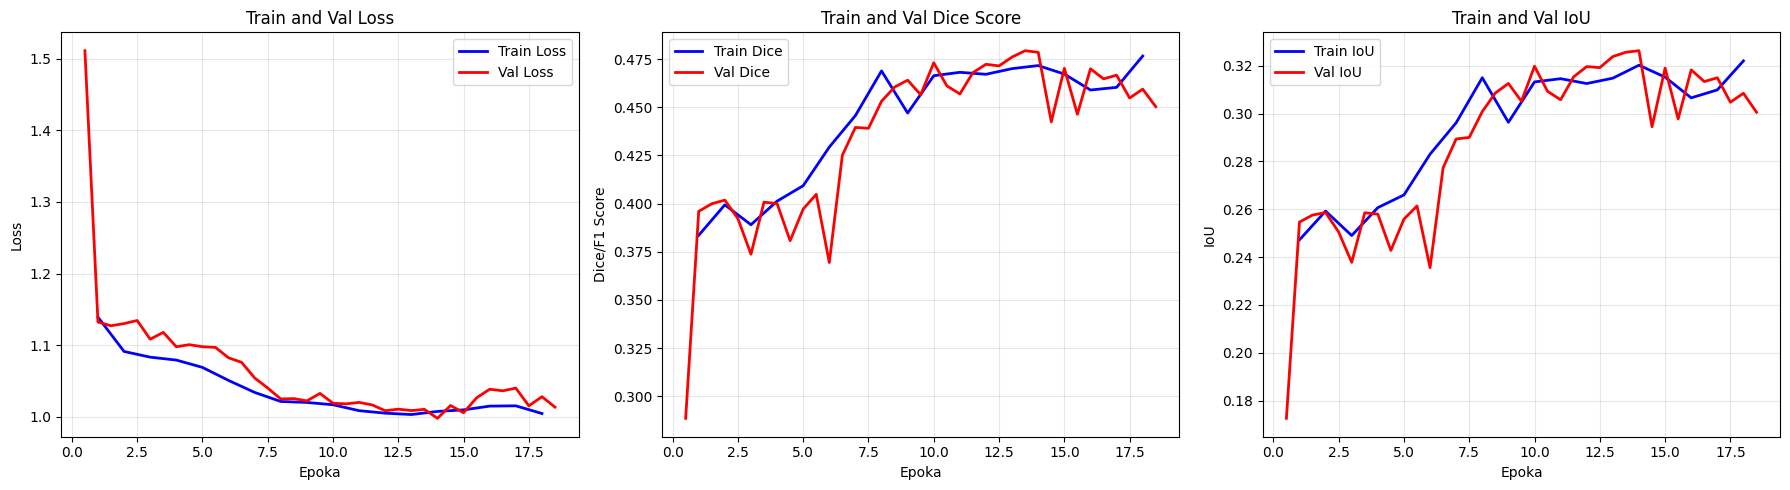

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Best val results:
Epoka: 13.5
Val Dice/F1: 0.4794
Val IoU: 0.3263

4. Testing...
Loading the best model: /home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=12-val_dice=0.479.ckpt
Rozmiary zbiorów: Train: 700, Val: 150, Test: 150
Testing DataLoader 0: 100%|██████████| 38/38 [00:02<00:00, 17.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_bce_loss         0.37130701541900635
        test_dice           0.5042018294334412
     test_dice_epoch        0.5042018294334412
     test_dice_loss         0.6135737895965576
        test_iou            0.3463536500930786
     test_iou_epoch         0.3463536500930786
        test_loss           0.9848811030387878
     test_loss_epoch        0.9848811030387878
──

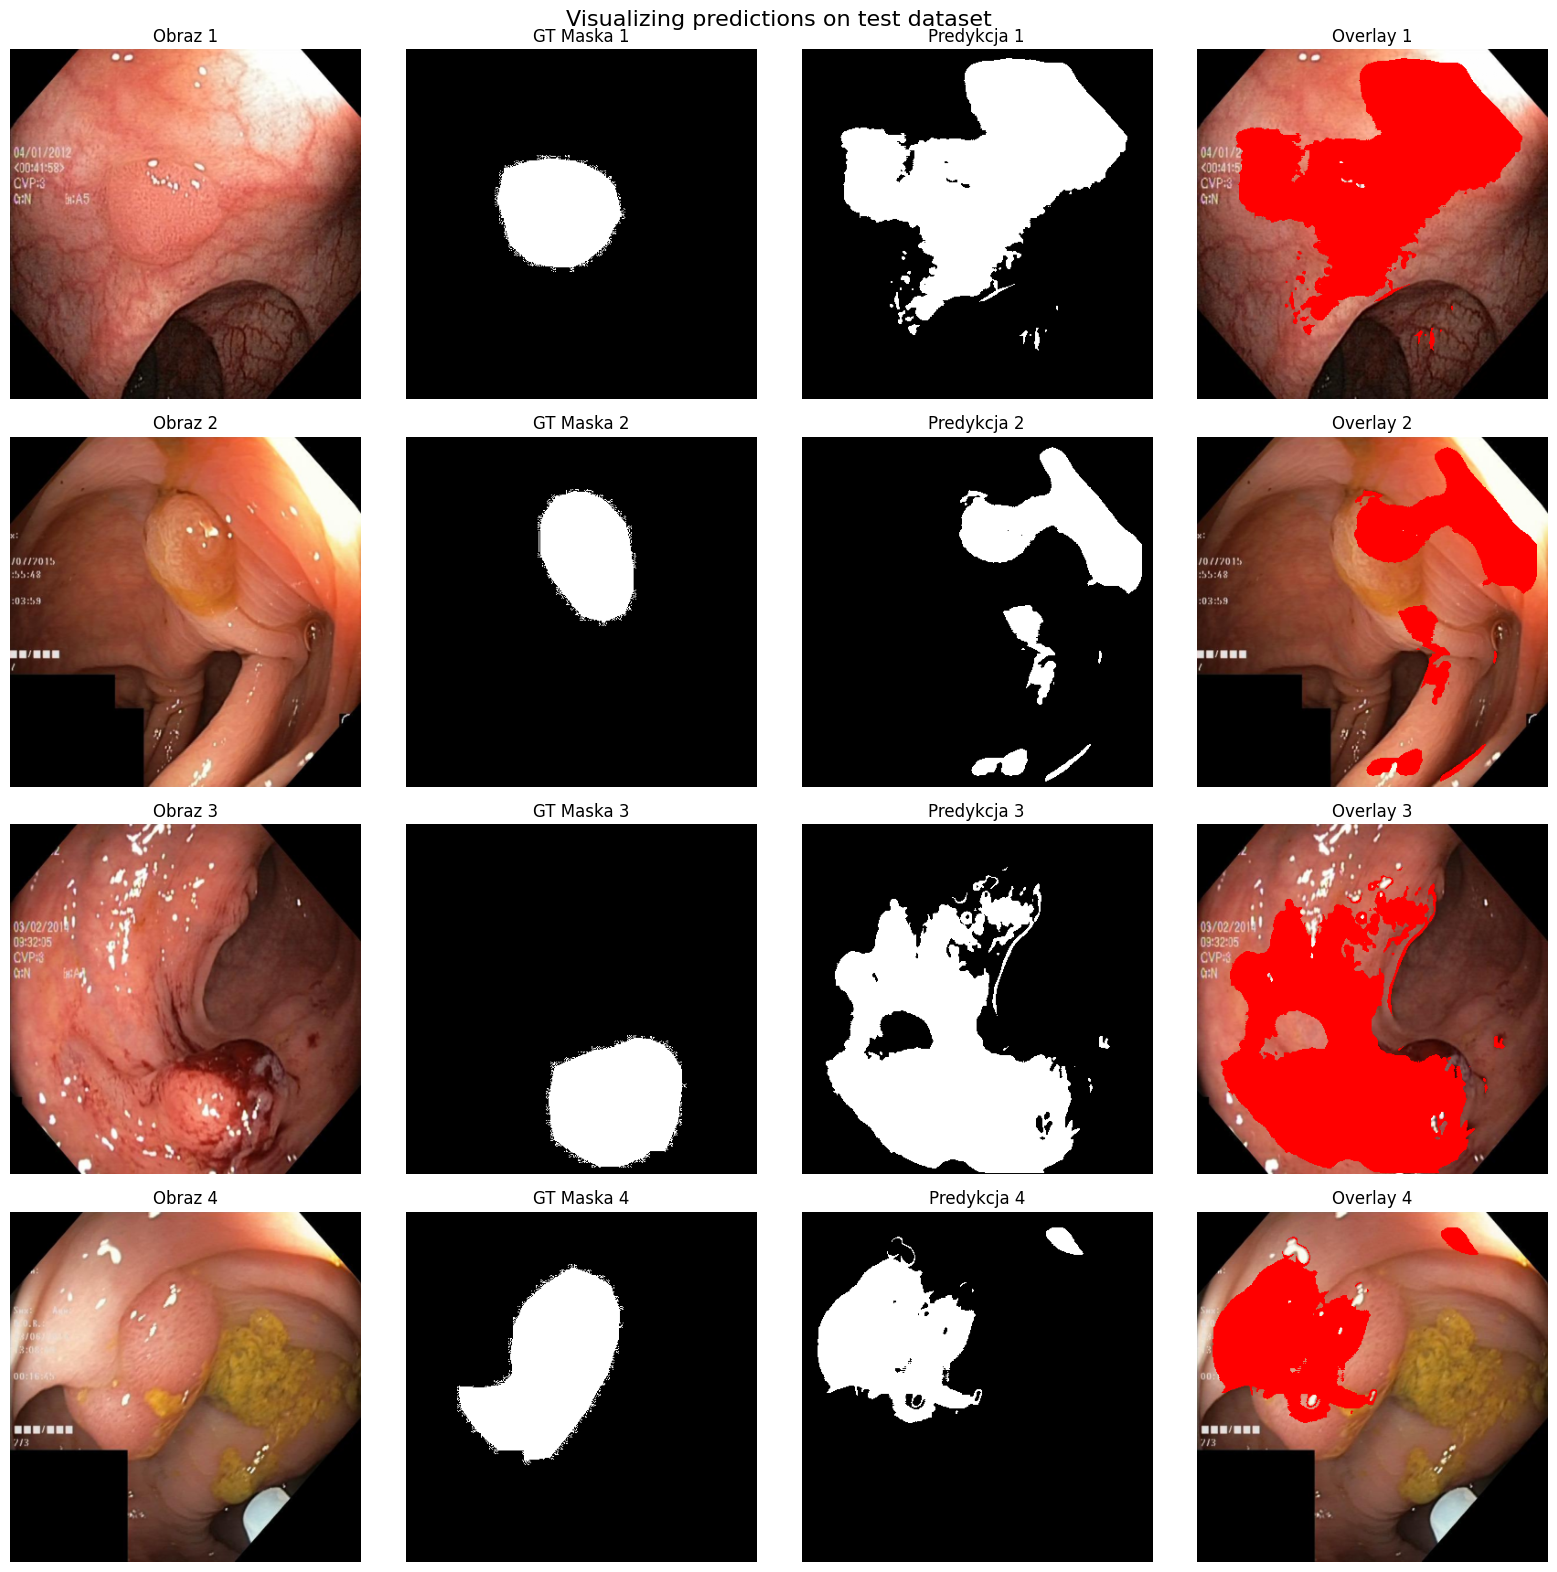


6. Analyzing prediction quality...
Prediction quality on a test batch:
IoU: 0.2483
F1/Dice: 0.3978

7. Checkpoints:
Best model: /home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/unet-best-epoch=12-val_dice=0.479.ckpt
Latest model: /home/karolina/studia/piaom/lab5/lightning_logs/version_2/checkpoints/last.ckpt

FINISHED TRAINING!


In [8]:
# 3. Wizualizacja przebiegu treningu
print("\n3. Metrics visualization")

metrics = metrics_callback.metrics

if metrics['epoch']:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Loss
    axes[0].plot(metrics['epoch'], metrics['train_loss'], 'b-', label='Train Loss', linewidth=2)
    # Create proper x-axis for validation (2 points per epoch)
    if metrics['val_loss']:
        val_epochs = np.arange(1, len(metrics['val_loss']) + 1) * 0.5
        axes[0].plot(val_epochs, metrics['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoka')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train and Val Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Dice/F1 Score
    axes[1].plot(metrics['epoch'], metrics['train_dice'], 'b-', label='Train Dice', linewidth=2)
    if metrics['val_dice']:
        val_epochs_dice = np.arange(1, len(metrics['val_dice']) + 1) * 0.5
        axes[1].plot(val_epochs_dice, metrics['val_dice'], 'r-', label='Val Dice', linewidth=2)
    axes[1].set_xlabel('Epoka')
    axes[1].set_ylabel('Dice/F1 Score')
    axes[1].set_title('Train and Val Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: IoU
    axes[2].plot(metrics['epoch'], metrics['train_iou'], 'b-', label='Train IoU', linewidth=2)
    if metrics['val_iou']:
        val_epochs_iou = np.arange(1, len(metrics['val_iou']) + 1) * 0.5
        axes[2].plot(val_epochs_iou, metrics['val_iou'], 'r-', label='Val IoU', linewidth=2)
    axes[2].set_xlabel('Epoka')
    axes[2].set_ylabel('IoU')
    axes[2].set_title('Train and Val IoU')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print best results
    if metrics['val_dice'] and metrics['val_iou']:
        best_val_f1 = max(metrics['val_dice'])
        best_val_iou = max(metrics['val_iou'])
        best_epoch_idx = metrics['val_dice'].index(best_val_f1)
        best_epoch = (best_epoch_idx + 1) * 0.5  # Convert to epoch number
        
        print(f"\nBest val results:")
        print(f"Epoka: {best_epoch:.1f}")
        print(f"Val Dice/F1: {best_val_f1:.4f}")
        print(f"Val IoU: {best_val_iou:.4f}")
    else:
        print("No validation metrics available")
else:
    print("No data to visualize...")

print("\n4. Testing...")

if checkpoint_callback.best_model_path:
    print(f"Loading the best model: {checkpoint_callback.best_model_path}")
    best_model = LitUNet.load_from_checkpoint(checkpoint_callback.best_model_path)
else:
    print("Using latest model...")
    best_model = model

test_results = trainer.test(best_model, dm)
print("Testing done")

print("\n5. Visualizing predictions...")

best_model.eval()

test_loader = dm.test_dataloader()
xb, yb = next(iter(test_loader))

with torch.no_grad():
    logits = best_model(xb)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

print(f"Visualizing batch: {xb.shape}")

n_examples = min(4, xb.shape[0])

fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4 * n_examples))

if n_examples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_examples):
    img = xb[i].permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5
    img = np.clip(img, 0, 1)
    
    gt_mask = yb[i, 0].numpy()
    
    pred_mask = preds[i, 0].numpy()
    
    overlay = img.copy()
    m = pred_mask > 0.5
    overlay[m] = [1.0, 0.0, 0.0]
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Obraz {i+1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(gt_mask, cmap='gray')
    axes[i, 1].set_title(f'GT Maska {i+1}')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title(f'Predykcja {i+1}')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title(f'Overlay {i+1}')
    axes[i, 3].axis('off')

plt.suptitle('Visualizing predictions on test dataset', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("\n6. Analyzing prediction quality...")

with torch.no_grad():
    test_iou = BinaryJaccardIndex()(preds.int(), yb.int())
    test_f1 = BinaryF1Score()(preds.int(), yb.int())
    
    print(f"Prediction quality on a test batch:")
    print(f"IoU: {test_iou:.4f}")
    print(f"F1/Dice: {test_f1:.4f}")

print("\n7. Checkpoints:")
if checkpoint_callback.best_model_path:
    print(f"Best model: {checkpoint_callback.best_model_path}")
if hasattr(checkpoint_callback, 'last_model_path') and checkpoint_callback.last_model_path:
    print(f"Latest model: {checkpoint_callback.last_model_path}")

print("\n" + "="*50)
print("FINISHED TRAINING!")
print("="*50)

## Zadanie 4 – Transfer Learning: U-Net z pre-trained ResNet Encoder

Znowu wykorzystamy transfer learning do zbudowania sieci o większej skuteczności. Zamiast używać całej nauczonej wcześniej sieci wyciągniemy tylko kilka warstw i użyjemy ich w enkoderze modelu U-Net.

1. **ResNetEncoder:**
   - Zaimplementuj klasę `ResNetEncoder`, która dziedziczy po `nn.Module`.
   - W `__init__` przyjmij: `pretrained=True` (czy ładować pretrenowane wagi), `freeze_encoder=False` (czy wczytane wagi mają być zamrożone).
   - Wczytaj pretrained ResNet18: `models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)`.
   - Wyciągnij warstwy enkodera:
     - `resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool` – początkowe warstwy.
     - `resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4` – bloki ResNet (64, 128, 256, 512 kanałów).
   - Jeśli `freeze_encoder=True`, ustaw wszystkie parametry na `requires_grad=False` wewnątrz bloku `for param in self.parameters():`
   - W metodzie `forward(x)` przepuść dane przez warstwy i zwróć 5 tensorów skip connections: `x1` (po conv1), `x2` (po layer1), `x3` (po layer2), `x4` (po layer3), `x5` (po layer4/bottleneck).

2. **UNetResNet:**
   - Zaimplementuj klasę `UNetResNet`, która dziedziczy po `nn.Module`.
   - W `__init__` przyjmij: `pretrained=True`, `freeze_encoder=False`, `dropout`.
   - Stwórz encoder: `self.encoder = ResNetEncoder(pretrained, freeze_encoder)`.
   - Zbuduj decoder (podobnie jak w poprzednim zadaniu):
     - `ConvTranspose2d` upsampling z bottleneck (u1).
     - `DoubleConv` pamiętaj o konkatenacji wyjścia z u1 i skip connection z x4.
     - `ConvTranspose2d` (u2).
     - `DoubleConv` u2 + x3.
     - `ConvTranspose2d` (u3).
     - `DoubleConv` u3 + x2.
     - `ConvTranspose2d` (u4).
     - `DoubleConv` u4 + x1.
     - `ConvTranspose2d` powrót do orygionalej rozdzielczości.
     - `DoubleConv`.
   - Warstwa wyjściowa `Conv2d` z jednym kanałem wyjściowym o rozmiarze 1x1.
   - W metodzie `forward(x)`:
     - Wywołaj encoder: `x1, x2, x3, x4, x5 = self.encoder(x)`.
     - Przepuść przez decoder i skip connections.
     - Zwróć logity.

3. **LitUNetResNet:**
   - Zaimplementuj Lightning wrapper analogicznie do `LitUNet`.
   - Dodaj metody pomocnicze:
     - `freeze_encoder()`: zamraża wagi enkodera (tylko decoder będzie trenowany).
     - `unfreeze_encoder()`: odmraża encoder (cała sieć będzie trenowana).

4. **Test architektury:**
   - Stwórz instancję `UNetResNet`.
   - Przepuść losowy tensor przez sieć i sprawdź kształt wyjścia.
   - Wyświetl osobno liczbę wszystkich oraz liczbę uczonych parametrów `sum(p.numel() for p in model_tl.parameters() if p.requires_grad)`

In [9]:
print("=== U-NET WITH RESNET ENCODER ===")

# 1. ResNetEncoder
class ResNetEncoder(nn.Module):
    def __init__(self, pretrained=True, freeze_encoder=False):
        super().__init__()
        resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1 
        self.layer2 = resnet.layer2 
        self.layer3 = resnet.layer3  
        self.layer4 = resnet.layer4
        
        if freeze_encoder:
            for param in self.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        
        x2 = self.maxpool(x1)
        x2 = self.layer1(x2)
        
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        
        return x1, x2, x3, x4, x5

# 2. UNetResNet
class UNetResNet(nn.Module):
    def __init__(self, pretrained=True, freeze_encoder=False, dropout=0.0):
        super().__init__()
        
        self.encoder = ResNetEncoder(pretrained, freeze_encoder)
        
        self.u1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.c1 = DoubleConv(512, 256, dropout)
        
        self.u2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.c2 = DoubleConv(256, 128, dropout)
        
        self.u3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.c3 = DoubleConv(128, 64, dropout)
        
        self.u4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.c4 = DoubleConv(128, 64, dropout)
        
        self.u5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.c5 = DoubleConv(32, 32, dropout)
        
        self.out = nn.Conv2d(32, 1, kernel_size=1)
    
    def forward(self, x):
        x1, x2, x3, x4, x5 = self.encoder(x)
        
        u1 = self.u1(x5)
        c1_in = torch.cat([u1, x4], dim=1)
        c1_out = self.c1(c1_in)
        
        u2 = self.u2(c1_out)
        c2_in = torch.cat([u2, x3], dim=1)
        c2_out = self.c2(c2_in)
        
        u3 = self.u3(c2_out)
        c3_in = torch.cat([u3, x2], dim=1)
        c3_out = self.c3(c3_in)
        
        u4 = self.u4(c3_out)
        c4_in = torch.cat([u4, x1], dim=1)
        c4_out = self.c4(c4_in)
        
        u5 = self.u5(c4_out)
        c5_out = self.c5(u5)
        
        out = self.out(c5_out)
        
        return out

# 3. LitUNetResNet
class LitUNetResNet(LightningModule):
    def __init__(self, pretrained=True, freeze_encoder=False, lr=1e-3, dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = UNetResNet(pretrained, freeze_encoder, dropout)
        
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()
        
        self.train_iou = BinaryJaccardIndex()
        self.val_iou = BinaryJaccardIndex()
        self.test_iou = BinaryJaccardIndex()
        
        self.train_f1 = BinaryF1Score()
        self.val_f1 = BinaryF1Score()
        self.test_f1 = BinaryF1Score()
        
        self.lr = lr
    
    def forward(self, x):
        return self.model(x)
    
    def freeze_encoder(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = False
        print("Encoder frozen")
    
    def unfreeze_encoder(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = True
        print("Encoder unfrozen")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler
        }
    
    def _shared_step(self, batch, batch_idx, prefix):
        x, y_true = batch
        
        y_pred = self(x)
        
        bce_loss = self.bce_loss(y_pred, y_true)
        dice_loss = self.dice_loss(y_pred, y_true)
        total_loss = bce_loss + dice_loss
        
        with torch.no_grad():
            y_pred_bin = (torch.sigmoid(y_pred) > 0.5).float()
            y_true_int = y_true.int()
            y_pred_int = y_pred_bin.int()
            
            if prefix == 'train':
                iou = self.train_iou(y_pred_int, y_true_int)
                f1 = self.train_f1(y_pred_int, y_true_int)
            elif prefix == 'val':
                iou = self.val_iou(y_pred_int, y_true_int)
                f1 = self.val_f1(y_pred_int, y_true_int)
            else:  # test
                iou = self.test_iou(y_pred_int, y_true_int)
                f1 = self.test_f1(y_pred_int, y_true_int)
        
        self.log(f'{prefix}_loss', total_loss, on_epoch=True, prog_bar=True)
        self.log(f'{prefix}_loss_epoch', total_loss, on_epoch=True, prog_bar=False)
        self.log(f'{prefix}_bce_loss', bce_loss, on_epoch=True)
        self.log(f'{prefix}_dice_loss', dice_loss, on_epoch=True)
        self.log(f'{prefix}_dice', f1, on_epoch=True, prog_bar=True)
        self.log(f'{prefix}_dice_epoch', f1, on_epoch=True, prog_bar=False)
        self.log(f'{prefix}_iou', iou, on_epoch=True, prog_bar=True)
        self.log(f'{prefix}_iou_epoch', iou, on_epoch=True, prog_bar=False)
        
        return total_loss
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'val')
    
    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'test')

print("\n4. testing architecturery...")

# Tworzenie modelu
model_resnet = UNetResNet(pretrained=True, freeze_encoder=False, dropout=0.1)

# Test forward pass
batch_size = 2
x_test = torch.randn(batch_size, 3, 384, 384)
with torch.no_grad():
    y_pred = model_resnet(x_test)

print(f"Input shape: {x_test.shape}")
print(f"Output shape: {y_pred.shape}")

# Liczba parametrów
total_params = sum(p.numel() for p in model_resnet.parameters())
trainable_params = sum(p.numel() for p in model_resnet.parameters() if p.requires_grad)

print(f"\nLiczba parametrów:")
print(f"Wszystkie: {total_params:,}")
print(f"Uczone: {trainable_params:,}")
print(f"Zamrożone: {total_params - trainable_params:,}")

# Test z zamrożonym enkoderem
print("\nTest z zamrożonym enkoderem:")
model_frozen = UNetResNet(pretrained=True, freeze_encoder=True, dropout=0.1)
frozen_params = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
print(f"Uczone parametry z zamrożonym enkoderem: {frozen_params:,}")

# Test Lightning wrapper
print("\nTest Lightning wrapper:")
lit_model_resnet = LitUNetResNet(pretrained=True, freeze_encoder=False, lr=1e-3, dropout=0.1)

# Test zamrażania/odmrażania
print("\nTest metod zamrażania/odmrażania:")
lit_model_resnet.freeze_encoder()
frozen_count = sum(p.numel() for p in lit_model_resnet.model.encoder.parameters() if p.requires_grad)
print(f"Uczone parametry enkodera po zamrożeniu: {frozen_count}")

lit_model_resnet.unfreeze_encoder()
unfrozen_count = sum(p.numel() for p in lit_model_resnet.model.encoder.parameters() if p.requires_grad)
print(f"Uczone parametry enkodera po odmrożeniu: {unfrozen_count}")

# Porównanie z oryginalnym U-Net
print("\nPorównanie z oryginalnym U-Net:")
model_unet = UNetSmall(in_ch=3, out_ch=1, dropout=0.1)
unet_params = sum(p.numel() for p in model_unet.parameters())
print(f"U-Net Small parametry: {unet_params:,}")
print(f"U-Net ResNet parametry: {total_params:,}")
print(f"Różnica: {total_params - unet_params:,}")

print("\n" + "="*50)
print("ARCHITEKTURA U-NET Z RESNET ENCODER ZAIMPLEMENTOWANA POMYŚLNIE!")
print("="*50)

=== U-NET WITH RESNET ENCODER ===

4. testing architecturery...
Input shape: torch.Size([2, 3, 384, 384])
Output shape: torch.Size([2, 1, 384, 384])

Liczba parametrów:
Wszystkie: 14,344,513
Uczone: 14,344,513
Zamrożone: 0

Test z zamrożonym enkoderem:
Uczone parametry z zamrożonym enkoderem: 3,168,001

Test Lightning wrapper:

Test metod zamrażania/odmrażania:
Encoder frozen
Uczone parametry enkodera po zamrożeniu: 0
Encoder unfrozen
Uczone parametry enkodera po odmrożeniu: 11176512

Porównanie z oryginalnym U-Net:
U-Net Small parametry: 7,702,977
U-Net ResNet parametry: 14,344,513
Różnica: 6,641,536

ARCHITEKTURA U-NET Z RESNET ENCODER ZAIMPLEMENTOWANA POMYŚLNIE!


## Zadanie 5 – Dwuetapowy Transfer Learning: Frozen Encoder

Trening chcemy wykonać podobnie jak w poprzednim ćwiczeniu, czyli zaczynamy od zamrożonych wag z transfer learningu, a potem wykonujemy fine-tuning. Proces treningu jest taki sam jak dla naszej wcześniejszej sieci.

**Trening z zamrożonym encoderem:**
1. Stwórz obiekt klasy `LitUNetResNet` z pretrenowanymi i zamrożonymi wagami.
2. Stwórz callbacki: `MetricsCallback`, `EarlyStopping`, `ModelCheckpoint`.
3. Stwórz `Trainer`.
4. Wywołaj trening sieci wywołując metodę `fit`
5. Wyświetl najlepszy checkpoint i val_dice.
6. Sprawdź oraz wyświetl metryki (3 wykresy: loss, dice, iou) podobnie jak we wcześniejszym treningu.
7. Wczytaj najlepszy model sieci i wykonaj dla niego testy na zbiorze testowym.
8. Wyświetl przykładowe predykcje (4 obrazy × 4 kolumny).

In [11]:
## Zadanie 5 – Dwuetapowy Transfer Learning: Frozen Encoder

print("=== TWO-STAGE TRANSFER LEARNING - FROZEN ENCODER ===")

print("\n1. Training with frozen encoder..")

dm_resnet = KvasirDataModule(
    img_paths=imgs,
    msk_paths=msks,
    batch_size=4,
    num_workers=2,
    train_split=0.7,
    val_split=0.15,
    img_size=(384, 384)
)

model_frozen = LitUNetResNet(
    pretrained=True,
    freeze_encoder=True,
    lr=1e-3,
    dropout=0.2
)

frozen_params = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_frozen.parameters())
print(f"Learnable parameters (decoder): {frozen_params:,}")
print(f"All params: {total_params:,}")
print(f"Percentage of trained parameters: {frozen_params/total_params*100:.1f}%")

metrics_callback_stage1 = MetricsCallback()

early_stopping_stage1 = EarlyStopping(
    monitor='val_dice',
    mode='max',
    patience=15, 
    verbose=True
)

checkpoint_callback_stage1 = ModelCheckpoint(
    monitor='val_dice',
    mode='max',
    save_top_k=1,
    save_last=True,
    filename='unet-resnet-stage1-best-{epoch:02d}-{val_dice:.3f}',
    verbose=True
)

trainer_stage1 = Trainer(
    max_epochs=30,
    accelerator='auto',
    devices=1,
    callbacks=[metrics_callback_stage1, early_stopping_stage1, checkpoint_callback_stage1],
    precision=16,
    log_every_n_steps=10
)

trainer_stage1.fit(model_frozen, dm_resnet)
print("Training finished")

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNetResNet         | 14.3 M | train
1 | bce_loss  | BCEWithLogitsLoss  | 0      | train
2 | dice_loss | DiceLoss           | 0      | train
3 | train_iou | BinaryJaccardIndex | 0      | train
4 | val_iou   | BinaryJaccardIndex | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
6 | train_f1  | BinaryF1Score      | 0      | train
7 | val_f1    | BinaryF1Score      | 0      | train
8 | test_f1   | BinaryF1Score      | 0      | train
---------------------------------------------------------
3.2 M     Trainable params
11.2 M    Non-trainable params
14.3 M    Total params
57.378    Total estimated model params size (MB)
131       Modules in train mode

=== TWO-STAGE TRANSFER LEARNING - FROZEN ENCODER ===

1. Training with frozen encoder..
Learnable parameters (decoder): 3,168,001
All params: 14,344,513
Percentage of trained parameters: 22.1%
Rozmiary zbiorów: Train: 700, Val: 150, Test: 150
Epoch 0: 100%|██████████| 175/175 [00:08<00:00, 20.75it/s, v_num=4, train_loss_step=0.573, train_dice_step=0.789, train_iou_step=0.651, val_loss=0.619, val_dice=0.723, val_iou=0.579, train_loss_epoch=0.901, train_dice_epoch=0.637, train_iou_epoch=0.481]

Metric val_dice improved. New best score: 0.723
Epoch 0, global step 175: 'val_dice' reached 0.72262 (best 0.72262), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=00-val_dice=0.723.ckpt' as top 1


Epoch 1: 100%|██████████| 175/175 [00:08<00:00, 20.54it/s, v_num=4, train_loss_step=0.370, train_dice_step=0.896, train_iou_step=0.812, val_loss=0.541, val_dice=0.745, val_iou=0.607, train_loss_epoch=0.669, train_dice_epoch=0.696, train_iou_epoch=0.543]

Metric val_dice improved by 0.022 >= min_delta = 0.0. New best score: 0.745
Epoch 1, global step 350: 'val_dice' reached 0.74485 (best 0.74485), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=01-val_dice=0.745.ckpt' as top 1


Epoch 2: 100%|██████████| 175/175 [00:08<00:00, 20.28it/s, v_num=4, train_loss_step=0.395, train_dice_step=0.822, train_iou_step=0.698, val_loss=0.480, val_dice=0.769, val_iou=0.638, train_loss_epoch=0.600, train_dice_epoch=0.727, train_iou_epoch=0.580]

Metric val_dice improved by 0.024 >= min_delta = 0.0. New best score: 0.769
Epoch 2, global step 525: 'val_dice' reached 0.76874 (best 0.76874), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=02-val_dice=0.769.ckpt' as top 1


Epoch 3: 100%|██████████| 175/175 [00:08<00:00, 20.56it/s, v_num=4, train_loss_step=0.430, train_dice_step=0.774, train_iou_step=0.632, val_loss=0.462, val_dice=0.774, val_iou=0.645, train_loss_epoch=0.574, train_dice_epoch=0.739, train_iou_epoch=0.595]

Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.774
Epoch 3, global step 700: 'val_dice' reached 0.77441 (best 0.77441), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=03-val_dice=0.774.ckpt' as top 1


Epoch 4: 100%|██████████| 175/175 [00:08<00:00, 20.56it/s, v_num=4, train_loss_step=0.792, train_dice_step=0.711, train_iou_step=0.551, val_loss=0.499, val_dice=0.766, val_iou=0.634, train_loss_epoch=0.536, train_dice_epoch=0.760, train_iou_epoch=0.624]

Epoch 4, global step 875: 'val_dice' was not in top 1


Epoch 5: 100%|██████████| 175/175 [00:08<00:00, 20.50it/s, v_num=4, train_loss_step=0.612, train_dice_step=0.574, train_iou_step=0.402, val_loss=0.443, val_dice=0.785, val_iou=0.660, train_loss_epoch=0.509, train_dice_epoch=0.758, train_iou_epoch=0.621]

Metric val_dice improved by 0.010 >= min_delta = 0.0. New best score: 0.785
Epoch 5, global step 1050: 'val_dice' reached 0.78468 (best 0.78468), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=05-val_dice=0.785.ckpt' as top 1


Epoch 6: 100%|██████████| 175/175 [00:08<00:00, 20.55it/s, v_num=4, train_loss_step=0.353, train_dice_step=0.809, train_iou_step=0.680, val_loss=0.422, val_dice=0.791, val_iou=0.670, train_loss_epoch=0.500, train_dice_epoch=0.774, train_iou_epoch=0.642]

Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.791
Epoch 6, global step 1225: 'val_dice' reached 0.79099 (best 0.79099), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=06-val_dice=0.791.ckpt' as top 1


Epoch 7: 100%|██████████| 175/175 [00:08<00:00, 20.66it/s, v_num=4, train_loss_step=0.457, train_dice_step=0.796, train_iou_step=0.661, val_loss=0.399, val_dice=0.804, val_iou=0.687, train_loss_epoch=0.471, train_dice_epoch=0.786, train_iou_epoch=0.657]

Metric val_dice improved by 0.013 >= min_delta = 0.0. New best score: 0.804
Epoch 7, global step 1400: 'val_dice' reached 0.80430 (best 0.80430), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=07-val_dice=0.804.ckpt' as top 1


Epoch 8: 100%|██████████| 175/175 [00:08<00:00, 20.45it/s, v_num=4, train_loss_step=0.325, train_dice_step=0.846, train_iou_step=0.733, val_loss=0.390, val_dice=0.808, val_iou=0.693, train_loss_epoch=0.452, train_dice_epoch=0.791, train_iou_epoch=0.664]

Metric val_dice improved by 0.004 >= min_delta = 0.0. New best score: 0.808
Epoch 8, global step 1575: 'val_dice' reached 0.80843 (best 0.80843), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=08-val_dice=0.808.ckpt' as top 1


Epoch 9: 100%|██████████| 175/175 [00:08<00:00, 20.56it/s, v_num=4, train_loss_step=0.557, train_dice_step=0.670, train_iou_step=0.504, val_loss=0.389, val_dice=0.809, val_iou=0.693, train_loss_epoch=0.454, train_dice_epoch=0.791, train_iou_epoch=0.663]

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.809
Epoch 9, global step 1750: 'val_dice' reached 0.80851 (best 0.80851), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=09-val_dice=0.809.ckpt' as top 1


Epoch 10: 100%|██████████| 175/175 [00:08<00:00, 20.63it/s, v_num=4, train_loss_step=0.235, train_dice_step=0.896, train_iou_step=0.812, val_loss=0.388, val_dice=0.810, val_iou=0.695, train_loss_epoch=0.438, train_dice_epoch=0.797, train_iou_epoch=0.672]

Metric val_dice improved by 0.001 >= min_delta = 0.0. New best score: 0.810
Epoch 10, global step 1925: 'val_dice' reached 0.80980 (best 0.80980), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=10-val_dice=0.810.ckpt' as top 1


Epoch 11: 100%|██████████| 175/175 [00:08<00:00, 20.54it/s, v_num=4, train_loss_step=0.430, train_dice_step=0.752, train_iou_step=0.603, val_loss=0.387, val_dice=0.809, val_iou=0.693, train_loss_epoch=0.454, train_dice_epoch=0.794, train_iou_epoch=0.667]

Epoch 11, global step 2100: 'val_dice' was not in top 1


Epoch 12: 100%|██████████| 175/175 [00:08<00:00, 20.62it/s, v_num=4, train_loss_step=0.381, train_dice_step=0.806, train_iou_step=0.675, val_loss=0.391, val_dice=0.809, val_iou=0.693, train_loss_epoch=0.446, train_dice_epoch=0.796, train_iou_epoch=0.671]

Epoch 12, global step 2275: 'val_dice' was not in top 1


Epoch 13: 100%|██████████| 175/175 [00:08<00:00, 20.52it/s, v_num=4, train_loss_step=1.040, train_dice_step=0.535, train_iou_step=0.366, val_loss=0.382, val_dice=0.812, val_iou=0.699, train_loss_epoch=0.453, train_dice_epoch=0.791, train_iou_epoch=0.665]

Metric val_dice improved by 0.003 >= min_delta = 0.0. New best score: 0.812
Epoch 13, global step 2450: 'val_dice' reached 0.81240 (best 0.81240), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=13-val_dice=0.812.ckpt' as top 1


Epoch 14: 100%|██████████| 175/175 [00:08<00:00, 20.56it/s, v_num=4, train_loss_step=0.394, train_dice_step=0.829, train_iou_step=0.708, val_loss=0.397, val_dice=0.805, val_iou=0.687, train_loss_epoch=0.463, train_dice_epoch=0.792, train_iou_epoch=0.667]

Epoch 14, global step 2625: 'val_dice' was not in top 1


Epoch 15: 100%|██████████| 175/175 [00:08<00:00, 20.49it/s, v_num=4, train_loss_step=0.351, train_dice_step=0.765, train_iou_step=0.619, val_loss=0.398, val_dice=0.805, val_iou=0.687, train_loss_epoch=0.457, train_dice_epoch=0.795, train_iou_epoch=0.668]

Epoch 15, global step 2800: 'val_dice' was not in top 1


Epoch 16: 100%|██████████| 175/175 [00:08<00:00, 20.52it/s, v_num=4, train_loss_step=0.479, train_dice_step=0.753, train_iou_step=0.603, val_loss=0.449, val_dice=0.788, val_iou=0.666, train_loss_epoch=0.471, train_dice_epoch=0.786, train_iou_epoch=0.657]

Epoch 16, global step 2975: 'val_dice' was not in top 1


Epoch 17: 100%|██████████| 175/175 [00:08<00:00, 20.43it/s, v_num=4, train_loss_step=0.350, train_dice_step=0.823, train_iou_step=0.699, val_loss=0.440, val_dice=0.785, val_iou=0.660, train_loss_epoch=0.492, train_dice_epoch=0.778, train_iou_epoch=0.647]

Epoch 17, global step 3150: 'val_dice' was not in top 1


Epoch 18: 100%|██████████| 175/175 [00:08<00:00, 20.52it/s, v_num=4, train_loss_step=0.271, train_dice_step=0.871, train_iou_step=0.772, val_loss=0.416, val_dice=0.802, val_iou=0.683, train_loss_epoch=0.477, train_dice_epoch=0.782, train_iou_epoch=0.651]

Epoch 18, global step 3325: 'val_dice' was not in top 1


Epoch 19: 100%|██████████| 175/175 [00:08<00:00, 20.64it/s, v_num=4, train_loss_step=0.587, train_dice_step=0.742, train_iou_step=0.590, val_loss=0.412, val_dice=0.800, val_iou=0.683, train_loss_epoch=0.467, train_dice_epoch=0.792, train_iou_epoch=0.663]

Epoch 19, global step 3500: 'val_dice' was not in top 1


Epoch 20: 100%|██████████| 175/175 [00:08<00:00, 20.64it/s, v_num=4, train_loss_step=0.778, train_dice_step=0.610, train_iou_step=0.439, val_loss=0.537, val_dice=0.746, val_iou=0.610, train_loss_epoch=0.465, train_dice_epoch=0.784, train_iou_epoch=0.654]

Epoch 20, global step 3675: 'val_dice' was not in top 1


Epoch 21: 100%|██████████| 175/175 [00:08<00:00, 20.53it/s, v_num=4, train_loss_step=0.459, train_dice_step=0.813, train_iou_step=0.685, val_loss=0.395, val_dice=0.806, val_iou=0.690, train_loss_epoch=0.457, train_dice_epoch=0.794, train_iou_epoch=0.668]

Epoch 21, global step 3850: 'val_dice' was not in top 1


Epoch 22: 100%|██████████| 175/175 [00:08<00:00, 20.54it/s, v_num=4, train_loss_step=0.253, train_dice_step=0.863, train_iou_step=0.760, val_loss=0.420, val_dice=0.805, val_iou=0.688, train_loss_epoch=0.457, train_dice_epoch=0.794, train_iou_epoch=0.670]

Epoch 22, global step 4025: 'val_dice' was not in top 1


Epoch 23: 100%|██████████| 175/175 [00:08<00:00, 20.43it/s, v_num=4, train_loss_step=0.237, train_dice_step=0.914, train_iou_step=0.841, val_loss=0.390, val_dice=0.812, val_iou=0.697, train_loss_epoch=0.427, train_dice_epoch=0.808, train_iou_epoch=0.687]

Epoch 23, global step 4200: 'val_dice' was not in top 1


Epoch 24: 100%|██████████| 175/175 [00:08<00:00, 20.48it/s, v_num=4, train_loss_step=0.238, train_dice_step=0.886, train_iou_step=0.795, val_loss=0.367, val_dice=0.824, val_iou=0.714, train_loss_epoch=0.407, train_dice_epoch=0.811, train_iou_epoch=0.692]

Metric val_dice improved by 0.012 >= min_delta = 0.0. New best score: 0.824
Epoch 24, global step 4375: 'val_dice' reached 0.82393 (best 0.82393), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=24-val_dice=0.824.ckpt' as top 1


Epoch 25: 100%|██████████| 175/175 [00:08<00:00, 20.36it/s, v_num=4, train_loss_step=0.270, train_dice_step=0.899, train_iou_step=0.816, val_loss=0.377, val_dice=0.820, val_iou=0.709, train_loss_epoch=0.369, train_dice_epoch=0.833, train_iou_epoch=0.721]

Epoch 25, global step 4550: 'val_dice' was not in top 1


Epoch 26: 100%|██████████| 175/175 [00:08<00:00, 20.41it/s, v_num=4, train_loss_step=0.155, train_dice_step=0.938, train_iou_step=0.883, val_loss=0.372, val_dice=0.820, val_iou=0.710, train_loss_epoch=0.367, train_dice_epoch=0.830, train_iou_epoch=0.719]

Epoch 26, global step 4725: 'val_dice' was not in top 1


Epoch 27: 100%|██████████| 175/175 [00:08<00:00, 20.46it/s, v_num=4, train_loss_step=0.272, train_dice_step=0.859, train_iou_step=0.753, val_loss=0.363, val_dice=0.826, val_iou=0.717, train_loss_epoch=0.371, train_dice_epoch=0.834, train_iou_epoch=0.724]

Metric val_dice improved by 0.002 >= min_delta = 0.0. New best score: 0.826
Epoch 27, global step 4900: 'val_dice' reached 0.82568 (best 0.82568), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=27-val_dice=0.826.ckpt' as top 1


Epoch 28: 100%|██████████| 175/175 [00:08<00:00, 20.52it/s, v_num=4, train_loss_step=0.278, train_dice_step=0.874, train_iou_step=0.776, val_loss=0.378, val_dice=0.818, val_iou=0.704, train_loss_epoch=0.340, train_dice_epoch=0.852, train_iou_epoch=0.750]

Epoch 28, global step 5075: 'val_dice' was not in top 1


Epoch 29: 100%|██████████| 175/175 [00:08<00:00, 20.49it/s, v_num=4, train_loss_step=0.297, train_dice_step=0.885, train_iou_step=0.794, val_loss=0.364, val_dice=0.824, val_iou=0.715, train_loss_epoch=0.327, train_dice_epoch=0.853, train_iou_epoch=0.750]

Epoch 29, global step 5250: 'val_dice' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 175/175 [00:08<00:00, 20.14it/s, v_num=4, train_loss_step=0.297, train_dice_step=0.885, train_iou_step=0.794, val_loss=0.364, val_dice=0.824, val_iou=0.715, train_loss_epoch=0.327, train_dice_epoch=0.853, train_iou_epoch=0.750]
Training finished


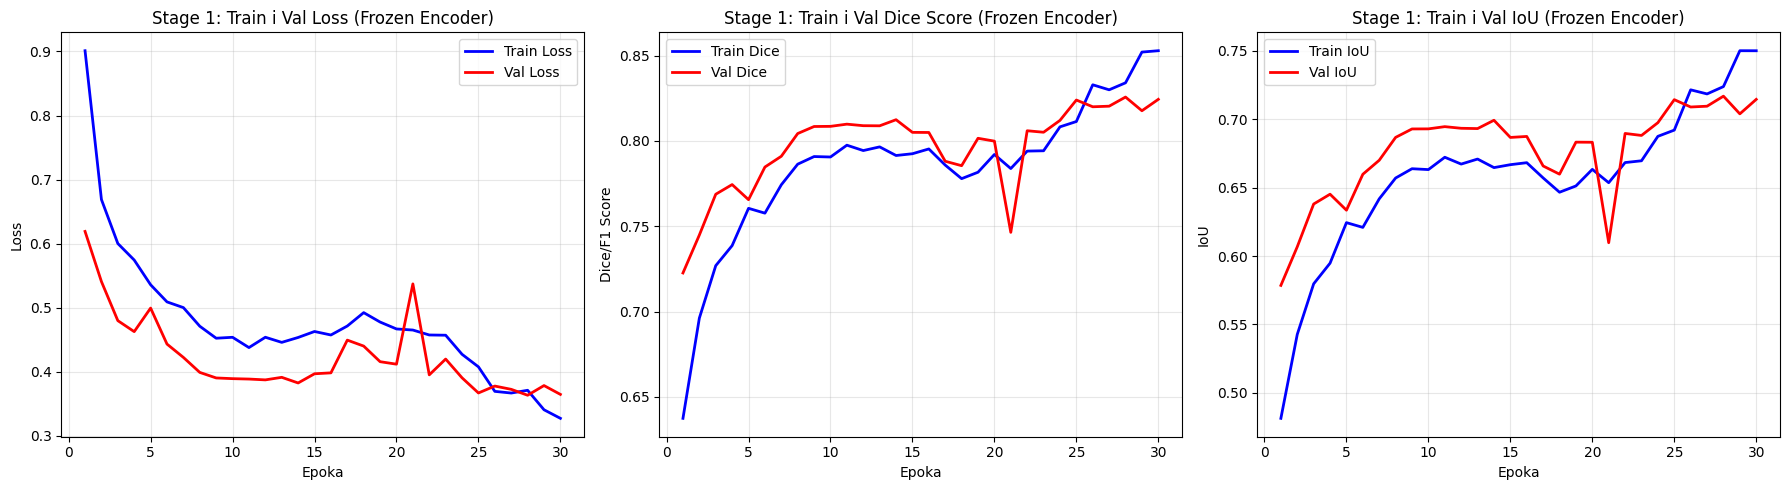

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Najlepsze wyniki Stage 1 (Frozen Encoder):
Epoka: 28
Val Dice/F1: 0.8257
Val IoU: 0.7169

3. Testowanie najlepszego modelu z Stage 1...
Ładowanie najlepszego modelu Stage 1: /home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=27-val_dice=0.826.ckpt
Testowanie na zbiorze testowym...
Rozmiary zbiorów: Train: 700, Val: 150, Test: 150
Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 55.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_bce_loss         0.13038873672485352
        test_dice           0.8570284843444824
     test_dice_epoch        0.8570284843444824
     test_dice_loss         0.16231368482112885
        test_iou            0.7563498616218567
     test_iou_epoch      

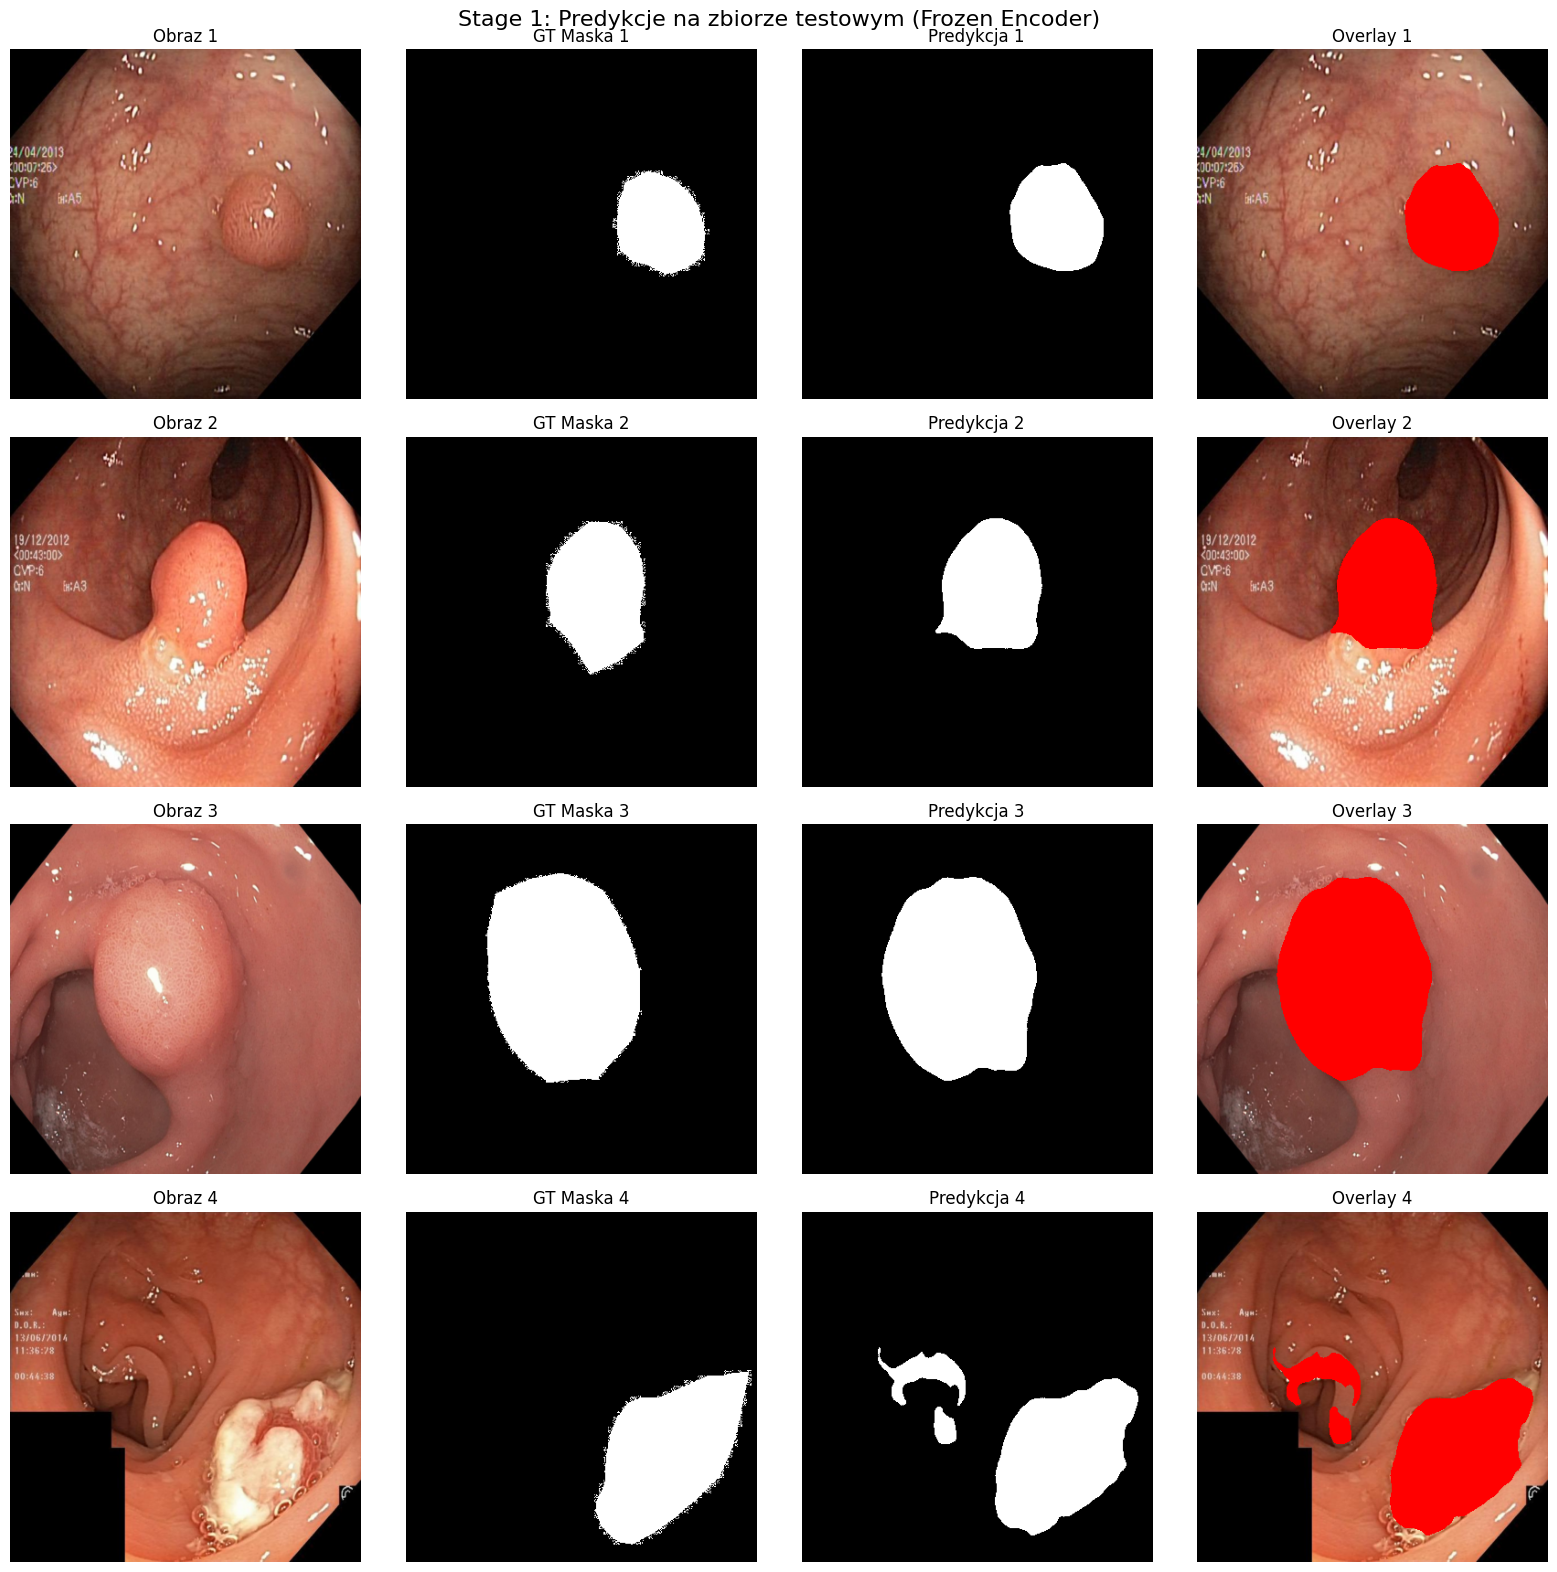


5. Analiza jakości predykcji Stage 1...
Jakość predykcji Stage 1 na przykładowym batchu testowym:
IoU: 0.8496
F1/Dice: 0.9187

6. Informacje o checkpointach Stage 1:
Najlepszy model Stage 1: /home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=27-val_dice=0.826.ckpt

STAGE 1 - TRENING Z ZAMROŻONYM ENCODEREM ZAKOŃCZONY!


In [13]:
metrics_stage1 = metrics_callback_stage1.metrics

if metrics_stage1['epoch']:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Wykres 1: Loss - POPRAWIONE
    axes[0].plot(metrics_stage1['epoch'], metrics_stage1['train_loss'], 'b-', label='Train Loss', linewidth=2)
    
    # Dla walidacji: jeśli jest więcej punktów niż epok, pomiń pierwszy (przed treningiem)
    if len(metrics_stage1['val_loss']) > len(metrics_stage1['epoch']):
        # Pomijamy pierwszy punkt walidacji (przed treningiem)
        axes[0].plot(metrics_stage1['epoch'], metrics_stage1['val_loss'][1:len(metrics_stage1['epoch'])+1], 'r-', label='Val Loss', linewidth=2)
    elif len(metrics_stage1['val_loss']) == len(metrics_stage1['epoch']):
        axes[0].plot(metrics_stage1['epoch'], metrics_stage1['val_loss'], 'r-', label='Val Loss', linewidth=2)
    else:
        # Jeśli mniej punktów walidacji
        axes[0].plot(metrics_stage1['epoch'][:len(metrics_stage1['val_loss'])], metrics_stage1['val_loss'], 'r-', label='Val Loss', linewidth=2)
    
    axes[0].set_xlabel('Epoka')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Stage 1: Train i Val Loss (Frozen Encoder)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Wykres 2: Dice/F1 Score - POPRAWIONE
    axes[1].plot(metrics_stage1['epoch'], metrics_stage1['train_dice'], 'b-', label='Train Dice', linewidth=2)
    
    if len(metrics_stage1['val_dice']) > len(metrics_stage1['epoch']):
        axes[1].plot(metrics_stage1['epoch'], metrics_stage1['val_dice'][1:len(metrics_stage1['epoch'])+1], 'r-', label='Val Dice', linewidth=2)
    elif len(metrics_stage1['val_dice']) == len(metrics_stage1['epoch']):
        axes[1].plot(metrics_stage1['epoch'], metrics_stage1['val_dice'], 'r-', label='Val Dice', linewidth=2)
    else:
        axes[1].plot(metrics_stage1['epoch'][:len(metrics_stage1['val_dice'])], metrics_stage1['val_dice'], 'r-', label='Val Dice', linewidth=2)
    
    axes[1].set_xlabel('Epoka')
    axes[1].set_ylabel('Dice/F1 Score')
    axes[1].set_title('Stage 1: Train i Val Dice Score (Frozen Encoder)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Wykres 3: IoU - POPRAWIONE
    axes[2].plot(metrics_stage1['epoch'], metrics_stage1['train_iou'], 'b-', label='Train IoU', linewidth=2)
    
    if len(metrics_stage1['val_iou']) > len(metrics_stage1['epoch']):
        axes[2].plot(metrics_stage1['epoch'], metrics_stage1['val_iou'][1:len(metrics_stage1['epoch'])+1], 'r-', label='Val IoU', linewidth=2)
    elif len(metrics_stage1['val_iou']) == len(metrics_stage1['epoch']):
        axes[2].plot(metrics_stage1['epoch'], metrics_stage1['val_iou'], 'r-', label='Val IoU', linewidth=2)
    else:
        axes[2].plot(metrics_stage1['epoch'][:len(metrics_stage1['val_iou'])], metrics_stage1['val_iou'], 'r-', label='Val IoU', linewidth=2)
    
    axes[2].set_xlabel('Epoka')
    axes[2].set_ylabel('IoU')
    axes[2].set_title('Stage 1: Train i Val IoU (Frozen Encoder)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Podsumowanie najlepszych wyników Stage 1
    if metrics_stage1['val_dice']:
        # Używaj tylko punktów walidacji odpowiadających epokom treningowym
        if len(metrics_stage1['val_dice']) > len(metrics_stage1['epoch']):
            val_dice_to_use = metrics_stage1['val_dice'][1:len(metrics_stage1['epoch'])+1]
        else:
            val_dice_to_use = metrics_stage1['val_dice']
            
        if len(metrics_stage1['val_iou']) > len(metrics_stage1['epoch']):
            val_iou_to_use = metrics_stage1['val_iou'][1:len(metrics_stage1['epoch'])+1]
        else:
            val_iou_to_use = metrics_stage1['val_iou']
        
        best_val_dice_stage1 = max(val_dice_to_use)
        best_val_iou_stage1 = max(val_iou_to_use)
        best_epoch_idx_stage1 = val_dice_to_use.index(best_val_dice_stage1)
        
        if best_epoch_idx_stage1 < len(metrics_stage1['epoch']):
            best_epoch_stage1 = metrics_stage1['epoch'][best_epoch_idx_stage1]
        else:
            best_epoch_stage1 = best_epoch_idx_stage1 + 1
        
        print(f"\nNajlepsze wyniki Stage 1 (Frozen Encoder):")
        print(f"Epoka: {best_epoch_stage1}")
        print(f"Val Dice/F1: {best_val_dice_stage1:.4f}")
        print(f"Val IoU: {best_val_iou_stage1:.4f}")
    else:
        print("Brak danych walidacyjnych dla Stage 1")
else:
    print("Brak danych do wizualizacji dla Stage 1")

# 3. Testowanie najlepszego modelu z Stage 1
print("\n3. Testowanie najlepszego modelu z Stage 1...")

# Wczytanie najlepszego modelu z Stage 1
if checkpoint_callback_stage1.best_model_path and checkpoint_callback_stage1.best_model_path != "":
    print(f"Ładowanie najlepszego modelu Stage 1: {checkpoint_callback_stage1.best_model_path}")
    best_model_stage1 = LitUNetResNet.load_from_checkpoint(checkpoint_callback_stage1.best_model_path)
else:
    print("Używanie ostatniego modelu z Stage 1")
    best_model_stage1 = model_frozen

# Testowanie na zbiorze testowym
print("Testowanie na zbiorze testowym...")
test_results_stage1 = trainer_stage1.test(best_model_stage1, dm_resnet)
print("✓ Testowanie Stage 1 zakończone")

# 4. Wizualizacja predykcji Stage 1
print("\n4. Wizualizacja predykcji Stage 1...")

best_model_stage1.eval()

# Pobierz batch z test loadera
test_loader_resnet = dm_resnet.test_dataloader()
xb_resnet, yb_resnet = next(iter(test_loader_resnet))

# Oblicz predykcje
with torch.no_grad():
    logits_stage1 = best_model_stage1(xb_resnet)
    probs_stage1 = torch.sigmoid(logits_stage1)
    preds_stage1 = (probs_stage1 > 0.5).float()

print(f"Batch do wizualizacji: {xb_resnet.shape}")

# Wizualizacja 4 przykładów
n_examples = min(4, xb_resnet.shape[0])

fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4 * n_examples))

if n_examples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_examples):
    # Oryginalny obraz (odwróć normalizację)
    img = xb_resnet[i].permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5
    img = np.clip(img, 0, 1)
    
    # Maska GT
    gt_mask = yb_resnet[i, 0].numpy()
    
    # Predykcja
    pred_mask = preds_stage1[i, 0].numpy()
    
    # Obraz z nałożoną predykcją
    overlay = img.copy()
    m = pred_mask > 0.5
    if overlay.shape[-1] == 3:  # RGB
        overlay[m] = [1.0, 0.0, 0.0]  # Czerwony dla predykcji
    
    # Kolumna 1: Oryginalny obraz
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Obraz {i+1}')
    axes[i, 0].axis('off')
    
    # Kolumna 2: Maska GT
    axes[i, 1].imshow(gt_mask, cmap='gray')
    axes[i, 1].set_title(f'GT Maska {i+1}')
    axes[i, 1].axis('off')
    
    # Kolumna 3: Predykcja
    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title(f'Predykcja {i+1}')
    axes[i, 2].axis('off')
    
    # Kolumna 4: Obraz z nałożoną predykcją
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title(f'Overlay {i+1}')
    axes[i, 3].axis('off')

plt.suptitle('Stage 1: Predykcje na zbiorze testowym (Frozen Encoder)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# 5. Analiza jakości predykcji Stage 1
print("\n5. Analiza jakości predykcji Stage 1...")

with torch.no_grad():
    # Oblicz metryki dla tego batcha
    test_iou_stage1 = BinaryJaccardIndex()(preds_stage1.int(), yb_resnet.int())
    test_f1_stage1 = BinaryF1Score()(preds_stage1.int(), yb_resnet.int())
    
    print(f"Jakość predykcji Stage 1 na przykładowym batchu testowym:")
    print(f"IoU: {test_iou_stage1:.4f}")
    print(f"F1/Dice: {test_f1_stage1:.4f}")

# 6. Informacje o checkpointach
print("\n6. Informacje o checkpointach Stage 1:")
if checkpoint_callback_stage1.best_model_path and checkpoint_callback_stage1.best_model_path != "":
    print(f"Najlepszy model Stage 1: {checkpoint_callback_stage1.best_model_path}")
    
    # Sprawdź metryki najlepszego modelu
    best_model_checkpoint = torch.load(checkpoint_callback_stage1.best_model_path)
    if 'callbacks' in best_model_checkpoint and 'ModelCheckpoint' in best_model_checkpoint['callbacks']:
        checkpoint_metrics = best_model_checkpoint['callbacks']['ModelCheckpoint']
        if 'best_model_score' in checkpoint_metrics:
            best_score = checkpoint_metrics['best_model_score']
            print(f"Best val_dice score: {best_score:.4f}")
else:
    print("Brak zapisanego najlepszego modelu Stage 1")

print("\n" + "="*60)
print("STAGE 1 - TRENING Z ZAMROŻONYM ENCODEREM ZAKOŃCZONY!")
print("="*60)

## Zadanie 6 – Dwuetapowy Transfer Learning: Fine-tuning

**Fine-tuning całej sieci:**
1. Odmroź encoder dla najlepszego modelu z poporzedniej części.
2. Ustaw learning rate: `best_stage1.hparams.lr = ` (podczas fine-tuningu zazwyczaj jest mniejszy).
3. Zaktualizuj hparam: `best_stage1.hparams.freeze_encoder = False`.
4. Stwórz nowe callbacki: `MetricsCallback`, `EarlyStopping`, `ModelCheckpoint`.
5. Stwórz nowy `Trainer`.
6. Wykonaj trening wywołując metodę `fit`.
7. Sprawdź oraz wyświetl metryki (3 wykresy: loss, dice, iou) podobnie jak we wcześniejszym treningu.
8. Wczytaj najlepszy model sieci i wykonaj dla niego testy na zbiorze testowym.
9. Wyświetl przykładowe predykcje (4 obrazy × 4 kolumny).

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | UNetResNet         | 14.3 M | train
1 | bce_loss  | BCEWithLogitsLoss  | 0      | train
2 | dice_loss | DiceLoss           | 0      | train
3 | train_iou | BinaryJaccardIndex | 0      | train
4 | val_iou   | BinaryJaccardIndex | 0      | train
5 | test_iou  | BinaryJaccardIndex | 0      | train
6 | train_f1  | BinaryF1Score      | 0      | train
7 | val_f1    | BinaryF1Score      | 0      | train
8 | test_f1   | BinaryF1Score      | 0      | train
---------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.378    Total estimated model params size (MB)
131       Modules in train mode

=== TWO-STAGE TRANSFER LEARNING - FINE-TUNING ===

1. Fine-tuning całej sieci...
Ładowanie najlepszego modelu z Stage 1: /home/karolina/studia/piaom/lab5/lightning_logs/version_4/checkpoints/unet-resnet-stage1-best-epoch=27-val_dice=0.826.ckpt
Odmrażanie enkodera...
Encoder unfrozen
Learning rate zmieniony: 0.001 -> 0.0001
Liczba uczonych parametrów po odmrożeniu: 14,344,513
Procent uczonych parametrów: 100.0%
Rozpoczynanie Stage 2 - Fine-tuning całej sieci...
Rozmiary zbiorów: Train: 700, Val: 150, Test: 150
Epoch 0: 100%|██████████| 175/175 [00:10<00:00, 16.63it/s, v_num=7, train_loss_step=0.976, train_dice_step=0.589, train_iou_step=0.418, val_loss=0.304, val_dice=0.853, val_iou=0.751, train_loss_epoch=0.409, train_dice_epoch=0.818, train_iou_epoch=0.702]

Metric val_dice improved. New best score: 0.853
Epoch 0, global step 175: 'val_dice' reached 0.85285 (best 0.85285), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_7/checkpoints/unet-resnet-stage2-best-epoch=00-val_dice=0.853.ckpt' as top 1


Epoch 1: 100%|██████████| 175/175 [00:10<00:00, 16.56it/s, v_num=7, train_loss_step=0.169, train_dice_step=0.937, train_iou_step=0.881, val_loss=0.300, val_dice=0.853, val_iou=0.753, train_loss_epoch=0.326, train_dice_epoch=0.853, train_iou_epoch=0.752]

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.853
Epoch 1, global step 350: 'val_dice' reached 0.85292 (best 0.85292), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_7/checkpoints/unet-resnet-stage2-best-epoch=01-val_dice=0.853.ckpt' as top 1


Epoch 2: 100%|██████████| 175/175 [00:10<00:00, 16.55it/s, v_num=7, train_loss_step=0.248, train_dice_step=0.910, train_iou_step=0.834, val_loss=0.300, val_dice=0.864, val_iou=0.769, train_loss_epoch=0.295, train_dice_epoch=0.873, train_iou_epoch=0.781]

Metric val_dice improved by 0.011 >= min_delta = 0.0. New best score: 0.864
Epoch 2, global step 525: 'val_dice' reached 0.86374 (best 0.86374), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_7/checkpoints/unet-resnet-stage2-best-epoch=02-val_dice=0.864.ckpt' as top 1


Epoch 3: 100%|██████████| 175/175 [00:10<00:00, 16.49it/s, v_num=7, train_loss_step=0.275, train_dice_step=0.893, train_iou_step=0.807, val_loss=0.308, val_dice=0.862, val_iou=0.767, train_loss_epoch=0.249, train_dice_epoch=0.890, train_iou_epoch=0.806] 

Epoch 3, global step 700: 'val_dice' was not in top 1


Epoch 4: 100%|██████████| 175/175 [00:10<00:00, 16.51it/s, v_num=7, train_loss_step=0.137, train_dice_step=0.937, train_iou_step=0.882, val_loss=0.277, val_dice=0.878, val_iou=0.790, train_loss_epoch=0.226, train_dice_epoch=0.900, train_iou_epoch=0.823] 

Metric val_dice improved by 0.015 >= min_delta = 0.0. New best score: 0.878
Epoch 4, global step 875: 'val_dice' reached 0.87833 (best 0.87833), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_7/checkpoints/unet-resnet-stage2-best-epoch=04-val_dice=0.878.ckpt' as top 1


Epoch 5: 100%|██████████| 175/175 [00:10<00:00, 16.52it/s, v_num=7, train_loss_step=0.156, train_dice_step=0.929, train_iou_step=0.867, val_loss=0.271, val_dice=0.878, val_iou=0.791, train_loss_epoch=0.197, train_dice_epoch=0.914, train_iou_epoch=0.846] 

Metric val_dice improved by 0.000 >= min_delta = 0.0. New best score: 0.878
Epoch 5, global step 1050: 'val_dice' reached 0.87834 (best 0.87834), saving model to '/home/karolina/studia/piaom/lab5/lightning_logs/version_7/checkpoints/unet-resnet-stage2-best-epoch=05-val_dice=0.878.ckpt' as top 1


Epoch 6: 100%|██████████| 175/175 [00:10<00:00, 16.52it/s, v_num=7, train_loss_step=0.109, train_dice_step=0.953, train_iou_step=0.910, val_loss=0.306, val_dice=0.862, val_iou=0.768, train_loss_epoch=0.168, train_dice_epoch=0.929, train_iou_epoch=0.869] 

Epoch 6, global step 1225: 'val_dice' was not in top 1


Epoch 7: 100%|██████████| 175/175 [00:10<00:00, 16.47it/s, v_num=7, train_loss_step=0.116, train_dice_step=0.954, train_iou_step=0.912, val_loss=0.282, val_dice=0.873, val_iou=0.784, train_loss_epoch=0.166, train_dice_epoch=0.930, train_iou_epoch=0.871] 

Epoch 7, global step 1400: 'val_dice' was not in top 1


Epoch 8: 100%|██████████| 175/175 [00:10<00:00, 16.45it/s, v_num=7, train_loss_step=0.213, train_dice_step=0.905, train_iou_step=0.826, val_loss=0.294, val_dice=0.866, val_iou=0.777, train_loss_epoch=0.150, train_dice_epoch=0.938, train_iou_epoch=0.885] 

Epoch 8, global step 1575: 'val_dice' was not in top 1


Epoch 9: 100%|██████████| 175/175 [00:10<00:00, 16.48it/s, v_num=7, train_loss_step=0.147, train_dice_step=0.930, train_iou_step=0.870, val_loss=0.286, val_dice=0.869, val_iou=0.779, train_loss_epoch=0.145, train_dice_epoch=0.941, train_iou_epoch=0.890] 

Epoch 9, global step 1750: 'val_dice' was not in top 1


Epoch 10: 100%|██████████| 175/175 [00:10<00:00, 16.47it/s, v_num=7, train_loss_step=0.232, train_dice_step=0.924, train_iou_step=0.859, val_loss=0.283, val_dice=0.870, val_iou=0.780, train_loss_epoch=0.149, train_dice_epoch=0.937, train_iou_epoch=0.883] 

Epoch 10, global step 1925: 'val_dice' was not in top 1


Epoch 11: 100%|██████████| 175/175 [00:10<00:00, 16.47it/s, v_num=7, train_loss_step=0.132, train_dice_step=0.927, train_iou_step=0.865, val_loss=0.285, val_dice=0.871, val_iou=0.781, train_loss_epoch=0.150, train_dice_epoch=0.936, train_iou_epoch=0.882] 

Epoch 11, global step 2100: 'val_dice' was not in top 1


Epoch 12: 100%|██████████| 175/175 [00:10<00:00, 16.46it/s, v_num=7, train_loss_step=0.210, train_dice_step=0.904, train_iou_step=0.825, val_loss=0.279, val_dice=0.874, val_iou=0.784, train_loss_epoch=0.146, train_dice_epoch=0.939, train_iou_epoch=0.886] 

Epoch 12, global step 2275: 'val_dice' was not in top 1


Epoch 13: 100%|██████████| 175/175 [00:10<00:00, 16.44it/s, v_num=7, train_loss_step=0.125, train_dice_step=0.945, train_iou_step=0.896, val_loss=0.291, val_dice=0.869, val_iou=0.776, train_loss_epoch=0.140, train_dice_epoch=0.943, train_iou_epoch=0.893] 

Epoch 13, global step 2450: 'val_dice' was not in top 1


Epoch 14: 100%|██████████| 175/175 [00:10<00:00, 16.49it/s, v_num=7, train_loss_step=0.198, train_dice_step=0.893, train_iou_step=0.807, val_loss=0.316, val_dice=0.855, val_iou=0.760, train_loss_epoch=0.146, train_dice_epoch=0.939, train_iou_epoch=0.885] 

Epoch 14, global step 2625: 'val_dice' was not in top 1


Epoch 15: 100%|██████████| 175/175 [00:10<00:00, 16.46it/s, v_num=7, train_loss_step=0.144, train_dice_step=0.950, train_iou_step=0.904, val_loss=0.312, val_dice=0.853, val_iou=0.756, train_loss_epoch=0.156, train_dice_epoch=0.935, train_iou_epoch=0.879] 

Monitored metric val_dice did not improve in the last 10 records. Best score: 0.878. Signaling Trainer to stop.
Epoch 15, global step 2800: 'val_dice' was not in top 1


Epoch 15: 100%|██████████| 175/175 [00:10<00:00, 16.06it/s, v_num=7, train_loss_step=0.144, train_dice_step=0.950, train_iou_step=0.904, val_loss=0.312, val_dice=0.853, val_iou=0.756, train_loss_epoch=0.156, train_dice_epoch=0.935, train_iou_epoch=0.879]
✓ Fine-tuning zakończony

2. Wizualizacja wyników Stage 2 (Fine-tuning)...
Długości list metryk Stage 2:
Epoch: 16
Train loss: 16
Val loss: 17
Train dice: 16
Val dice: 17
Train iou: 16
Val iou: 17


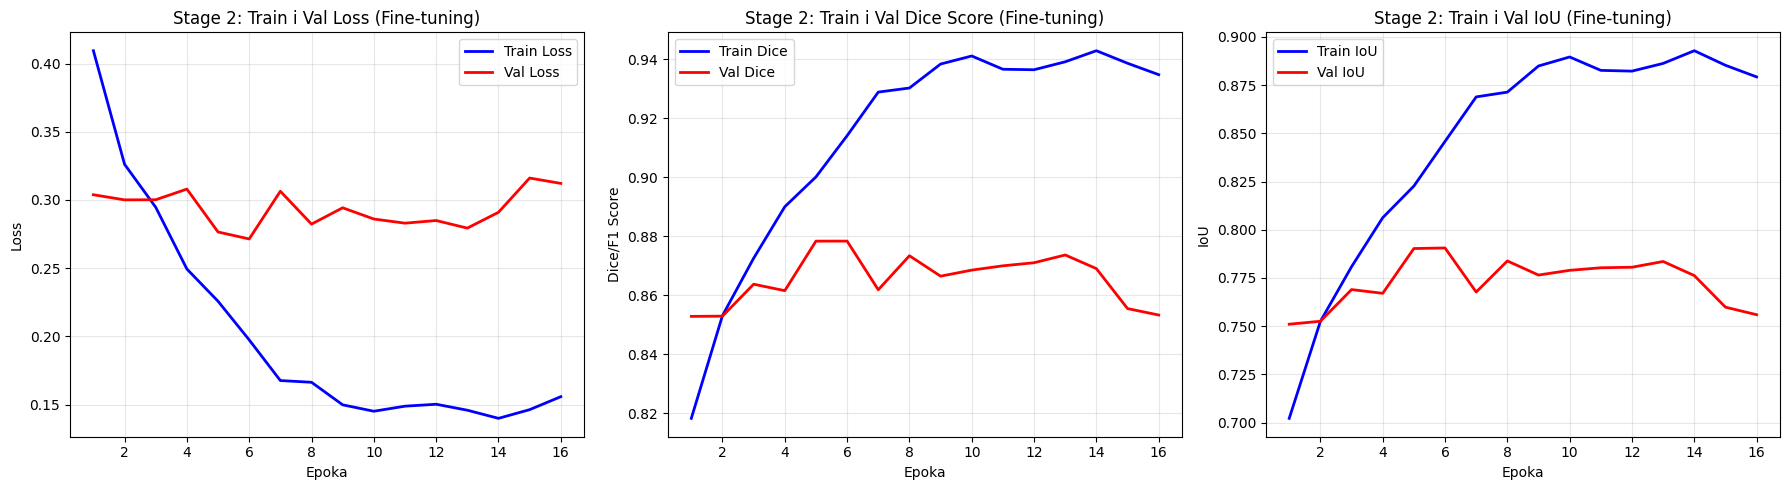

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Najlepsze wyniki Stage 2 (Fine-tuning):
Epoka: 6
Val Dice/F1: 0.8783
Val IoU: 0.7906

Poprawa Dice po fine-tuningu: 0.0527
Względna poprawa: 6.38%

3. Testowanie najlepszego modelu z Stage 2...
Ładowanie najlepszego modelu Stage 2: /home/karolina/studia/piaom/lab5/lightning_logs/version_7/checkpoints/unet-resnet-stage2-best-epoch=05-val_dice=0.878.ckpt
Testowanie na zbiorze testowym...
Rozmiary zbiorów: Train: 700, Val: 150, Test: 150
Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 56.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_bce_loss         0.09465090930461884
        test_dice           0.9124522805213928
     test_dice_epoch        0.9124522805213928
     test_dice_loss         0.10714750736951828
        test_i

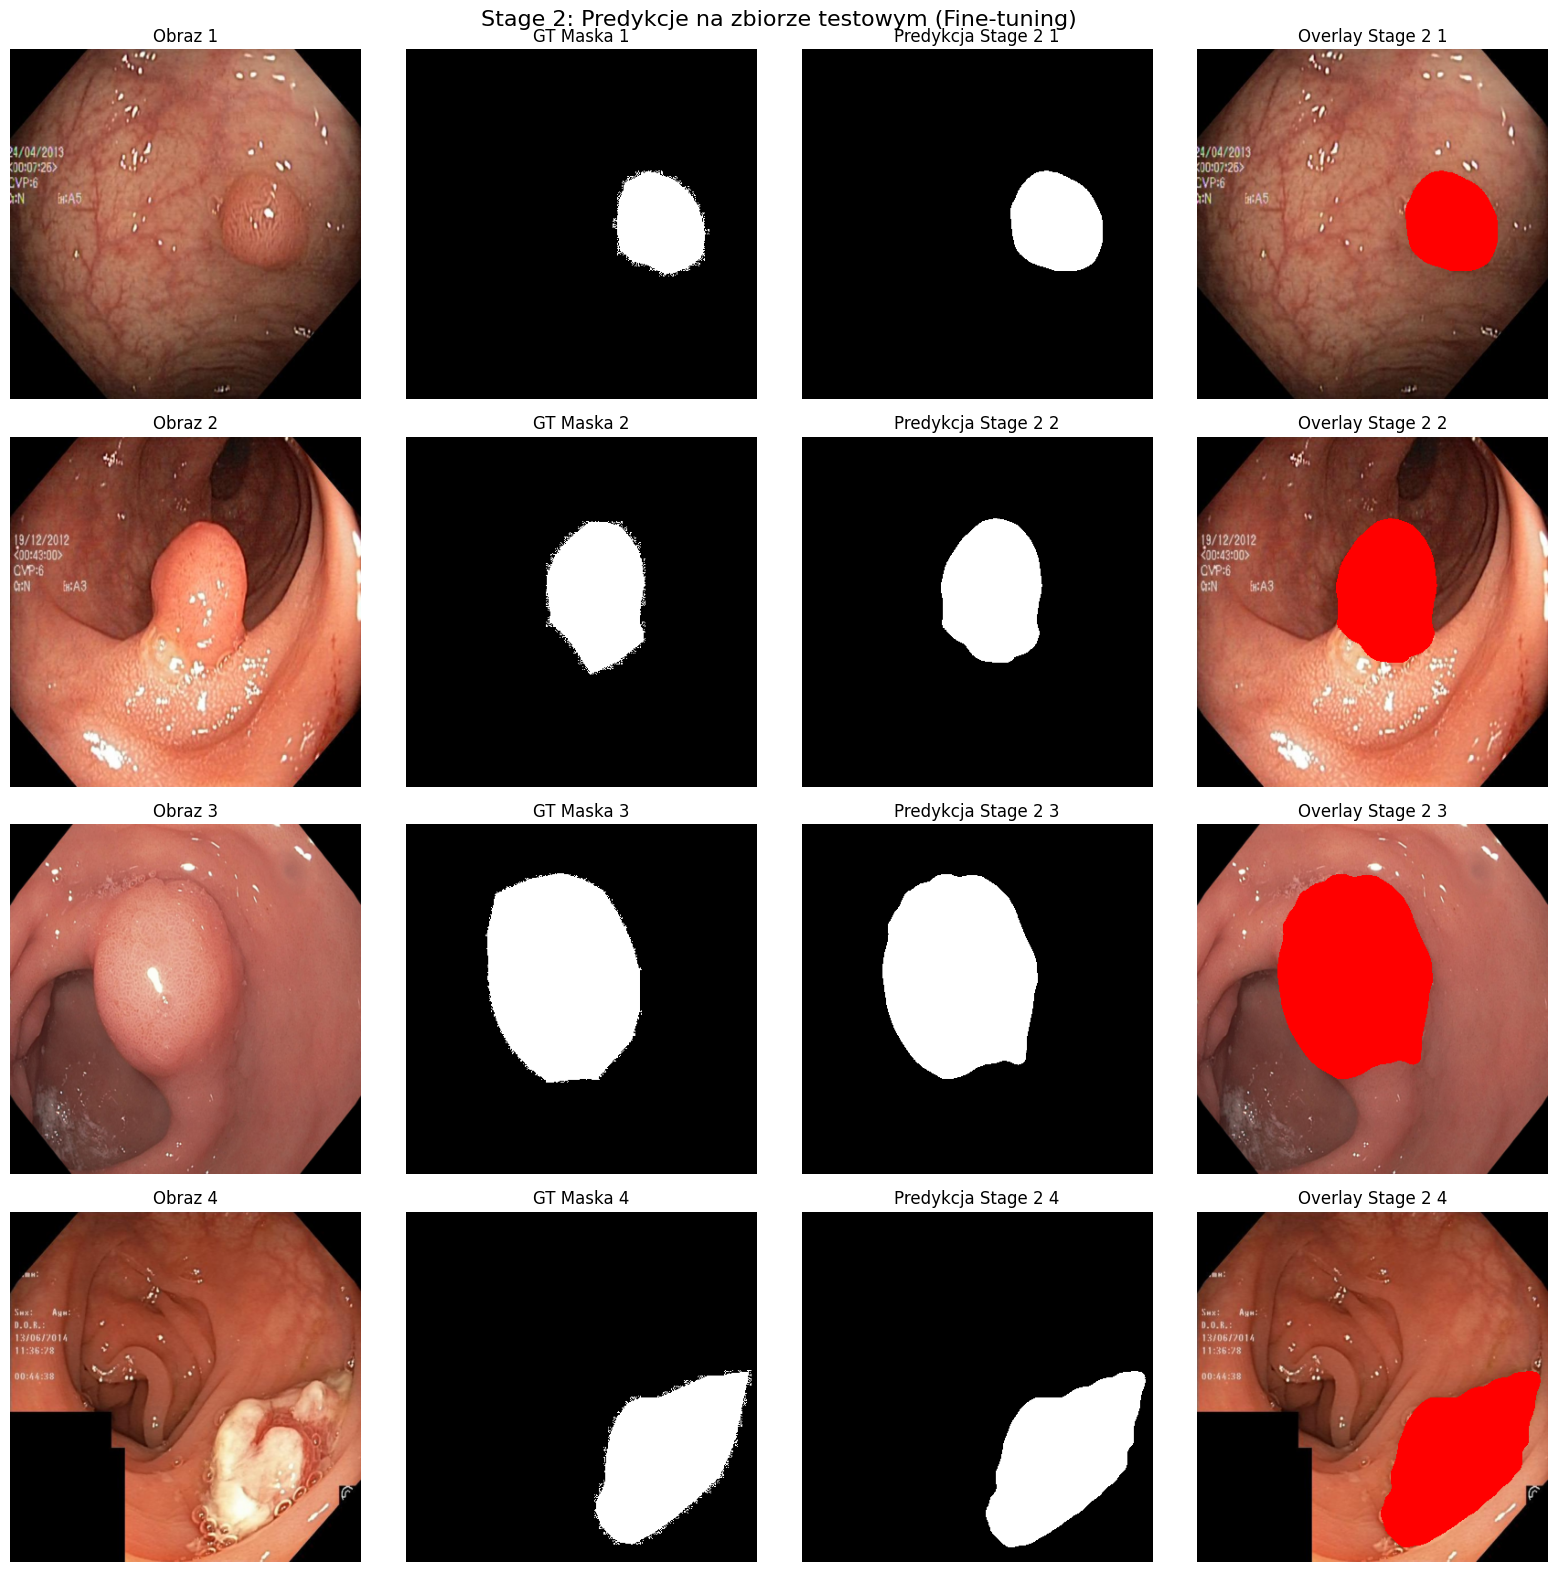


5. Analiza jakości predykcji Stage 2 i porównanie...
Jakość predykcji Stage 2 na przykładowym batchu testowym:
IoU: 0.9263
F1/Dice: 0.9617

Porównanie z Stage 1 (na tym samym batchu):
IoU:  0.8496 -> 0.9263 (Δ+0.0767)
F1:   0.9187 -> 0.9617 (Δ+0.0431)

6. Informacje o checkpointach Stage 2:
Najlepszy model Stage 2: /home/karolina/studia/piaom/lab5/lightning_logs/version_7/checkpoints/unet-resnet-stage2-best-epoch=05-val_dice=0.878.ckpt

PODSUMOWANIE DWUETAPOWEGO TRANSFER LEARNINGU
Stage 1 (Frozen Encoder): Val Dice = 0.8257
Stage 2 (Fine-tuning):    Val Dice = 0.8783
Poprawa:                  Δ = +0.0527
Względna poprawa:         6.38%

Fine-tuning zakończony sukcesem! 🎉

DWUETAPOWY TRANSFER LEARNING ZAKOŃCZONY!


In [16]:
## Zadanie 6 – Dwuetapowy Transfer Learning: Fine-tuning

print("=== TWO-STAGE TRANSFER LEARNING - FINE-TUNING ===")

# 1. Fine-tuning całej sieci
print("\n1. Fine-tuning całej sieci...")

# Sprawdź czy mamy najlepszy model z Stage 1
if checkpoint_callback_stage1.best_model_path and checkpoint_callback_stage1.best_model_path != "":
    print(f"Ładowanie najlepszego modelu z Stage 1: {checkpoint_callback_stage1.best_model_path}")
    
    # Wczytaj najlepszy model z Stage 1
    best_model_stage1 = LitUNetResNet.load_from_checkpoint(checkpoint_callback_stage1.best_model_path)
    
    # 2. Odmrożenie enkodera i konfiguracja fine-tuningu
    print("Odmrażanie enkodera...")
    best_model_stage1.unfreeze_encoder()  # Odmrożenie enkodera
    
    # Ustaw mniejszy learning rate dla fine-tuningu
    original_lr = best_model_stage1.lr
    fine_tune_lr = original_lr * 0.1  # 10x mniejszy learning rate
    best_model_stage1.lr = fine_tune_lr
    best_model_stage1.hparams.lr = fine_tune_lr
    best_model_stage1.hparams.freeze_encoder = False
    
    print(f"Learning rate zmieniony: {original_lr} -> {fine_tune_lr}")
    
    # Sprawdzenie liczby uczonych parametrów po odmrożeniu
    unfrozen_params = sum(p.numel() for p in best_model_stage1.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in best_model_stage1.parameters())
    print(f"Liczba uczonych parametrów po odmrożeniu: {unfrozen_params:,}")
    print(f"Procent uczonych parametrów: {unfrozen_params/total_params*100:.1f}%")
    
    # 3. Callbacki dla fine-tuningu
    metrics_callback_stage2 = MetricsCallback()
    
    early_stopping_stage2 = EarlyStopping(
        monitor='val_dice',
        mode='max',
        patience=10,  # Mniejsza cierpliwość dla fine-tuningu
        verbose=True
    )
    
    checkpoint_callback_stage2 = ModelCheckpoint(
        monitor='val_dice',
        mode='max',
        save_top_k=1,
        save_last=True,
        filename='unet-resnet-stage2-best-{epoch:02d}-{val_dice:.3f}',
        verbose=True
    )
    
    # 4. Trainer dla fine-tuningu
    trainer_stage2 = Trainer(
        max_epochs=20,  # Mniej epok dla fine-tuningu
        accelerator='auto',
        devices=1,
        callbacks=[metrics_callback_stage2, early_stopping_stage2, checkpoint_callback_stage2],
        precision=16,
        log_every_n_steps=10
    )
    
    print("Rozpoczynanie Stage 2 - Fine-tuning całej sieci...")
    trainer_stage2.fit(best_model_stage1, dm_resnet)
    print("✓ Fine-tuning zakończony")
    
    # 5. Wizualizacja wyników Stage 2
    print("\n2. Wizualizacja wyników Stage 2 (Fine-tuning)...")
    
    metrics_stage2 = metrics_callback_stage2.metrics
    
    # Debug: sprawdź długości list
    print(f"Długości list metryk Stage 2:")
    print(f"Epoch: {len(metrics_stage2['epoch'])}")
    print(f"Train loss: {len(metrics_stage2['train_loss'])}")
    print(f"Val loss: {len(metrics_stage2['val_loss'])}")
    print(f"Train dice: {len(metrics_stage2['train_dice'])}")
    print(f"Val dice: {len(metrics_stage2['val_dice'])}")
    print(f"Train iou: {len(metrics_stage2['train_iou'])}")
    print(f"Val iou: {len(metrics_stage2['val_iou'])}")
    
    if metrics_stage2['epoch']:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Wykres 1: Loss - POPRAWIONE
        axes[0].plot(metrics_stage2['epoch'], metrics_stage2['train_loss'], 'b-', label='Train Loss', linewidth=2)
        
        # Dla walidacji: jeśli jest więcej punktów niż epok, pomiń pierwszy (przed treningiem)
        if len(metrics_stage2['val_loss']) > len(metrics_stage2['epoch']):
            # Pomijamy pierwszy punkt walidacji (przed treningiem)
            axes[0].plot(metrics_stage2['epoch'], metrics_stage2['val_loss'][1:len(metrics_stage2['epoch'])+1], 'r-', label='Val Loss', linewidth=2)
        elif len(metrics_stage2['val_loss']) == len(metrics_stage2['epoch']):
            axes[0].plot(metrics_stage2['epoch'], metrics_stage2['val_loss'], 'r-', label='Val Loss', linewidth=2)
        else:
            # Jeśli mniej punktów walidacji
            axes[0].plot(metrics_stage2['epoch'][:len(metrics_stage2['val_loss'])], metrics_stage2['val_loss'], 'r-', label='Val Loss', linewidth=2)
        
        axes[0].set_xlabel('Epoka')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Stage 2: Train i Val Loss (Fine-tuning)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Wykres 2: Dice/F1 Score - POPRAWIONE
        axes[1].plot(metrics_stage2['epoch'], metrics_stage2['train_dice'], 'b-', label='Train Dice', linewidth=2)
        
        if len(metrics_stage2['val_dice']) > len(metrics_stage2['epoch']):
            axes[1].plot(metrics_stage2['epoch'], metrics_stage2['val_dice'][1:len(metrics_stage2['epoch'])+1], 'r-', label='Val Dice', linewidth=2)
        elif len(metrics_stage2['val_dice']) == len(metrics_stage2['epoch']):
            axes[1].plot(metrics_stage2['epoch'], metrics_stage2['val_dice'], 'r-', label='Val Dice', linewidth=2)
        else:
            axes[1].plot(metrics_stage2['epoch'][:len(metrics_stage2['val_dice'])], metrics_stage2['val_dice'], 'r-', label='Val Dice', linewidth=2)
        
        axes[1].set_xlabel('Epoka')
        axes[1].set_ylabel('Dice/F1 Score')
        axes[1].set_title('Stage 2: Train i Val Dice Score (Fine-tuning)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Wykres 3: IoU - POPRAWIONE
        axes[2].plot(metrics_stage2['epoch'], metrics_stage2['train_iou'], 'b-', label='Train IoU', linewidth=2)
        
        if len(metrics_stage2['val_iou']) > len(metrics_stage2['epoch']):
            axes[2].plot(metrics_stage2['epoch'], metrics_stage2['val_iou'][1:len(metrics_stage2['epoch'])+1], 'r-', label='Val IoU', linewidth=2)
        elif len(metrics_stage2['val_iou']) == len(metrics_stage2['epoch']):
            axes[2].plot(metrics_stage2['epoch'], metrics_stage2['val_iou'], 'r-', label='Val IoU', linewidth=2)
        else:
            axes[2].plot(metrics_stage2['epoch'][:len(metrics_stage2['val_iou'])], metrics_stage2['val_iou'], 'r-', label='Val IoU', linewidth=2)
        
        axes[2].set_xlabel('Epoka')
        axes[2].set_ylabel('IoU')
        axes[2].set_title('Stage 2: Train i Val IoU (Fine-tuning)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Podsumowanie najlepszych wyników Stage 2
        if metrics_stage2['val_dice']:
            # Używaj tylko punktów walidacji odpowiadających epokom treningowym
            if len(metrics_stage2['val_dice']) > len(metrics_stage2['epoch']):
                val_dice_to_use = metrics_stage2['val_dice'][1:len(metrics_stage2['epoch'])+1]
            else:
                val_dice_to_use = metrics_stage2['val_dice']
                
            if len(metrics_stage2['val_iou']) > len(metrics_stage2['epoch']):
                val_iou_to_use = metrics_stage2['val_iou'][1:len(metrics_stage2['epoch'])+1]
            else:
                val_iou_to_use = metrics_stage2['val_iou']
            
            best_val_dice_stage2 = max(val_dice_to_use)
            best_val_iou_stage2 = max(val_iou_to_use)
            best_epoch_idx_stage2 = val_dice_to_use.index(best_val_dice_stage2)
            
            if best_epoch_idx_stage2 < len(metrics_stage2['epoch']):
                best_epoch_stage2 = metrics_stage2['epoch'][best_epoch_idx_stage2]
            else:
                best_epoch_stage2 = best_epoch_idx_stage2 + 1
            
            print(f"\nNajlepsze wyniki Stage 2 (Fine-tuning):")
            print(f"Epoka: {best_epoch_stage2}")
            print(f"Val Dice/F1: {best_val_dice_stage2:.4f}")
            print(f"Val IoU: {best_val_iou_stage2:.4f}")
            
            # Porównanie z Stage 1
            if metrics_stage1['val_dice']:
                # Używaj tylko punktów walidacji odpowiadających epokom treningowym dla Stage 1
                if len(metrics_stage1['val_dice']) > len(metrics_stage1['epoch']):
                    val_dice_stage1_to_use = metrics_stage1['val_dice'][1:len(metrics_stage1['epoch'])+1]
                else:
                    val_dice_stage1_to_use = metrics_stage1['val_dice']
                    
                best_val_dice_stage1 = max(val_dice_stage1_to_use)
                improvement_dice = best_val_dice_stage2 - best_val_dice_stage1
                print(f"\nPoprawa Dice po fine-tuningu: {improvement_dice:.4f}")
                print(f"Względna poprawa: {improvement_dice/best_val_dice_stage1*100:.2f}%")
        else:
            print("Brak danych walidacyjnych dla Stage 2")
    else:
        print("Brak danych do wizualizacji dla Stage 2")
    
    # 6. Testowanie najlepszego modelu z Stage 2
    print("\n3. Testowanie najlepszego modelu z Stage 2...")
    
    # Wczytanie najlepszego modelu z Stage 2
    if checkpoint_callback_stage2.best_model_path and checkpoint_callback_stage2.best_model_path != "":
        print(f"Ładowanie najlepszego modelu Stage 2: {checkpoint_callback_stage2.best_model_path}")
        best_model_stage2 = LitUNetResNet.load_from_checkpoint(checkpoint_callback_stage2.best_model_path)
    else:
        print("Używanie ostatniego modelu z Stage 2")
        best_model_stage2 = best_model_stage1
    
    # Testowanie na zbiorze testowym
    print("Testowanie na zbiorze testowym...")
    test_results_stage2 = trainer_stage2.test(best_model_stage2, dm_resnet)
    print("✓ Testowanie Stage 2 zakończone")
    
    # 7. Wizualizacja predykcji Stage 2
    print("\n4. Wizualizacja predykcji Stage 2...")
    
    best_model_stage2.eval()
    
    # Oblicz predykcje dla tego samego batcha co w Stage 1 dla porównania
    with torch.no_grad():
        logits_stage2 = best_model_stage2(xb_resnet)
        probs_stage2 = torch.sigmoid(logits_stage2)
        preds_stage2 = (probs_stage2 > 0.5).float()
    
    # Wizualizacja 4 przykładów - TE SAME obrazy co w Stage 1 dla porównania
    n_examples = min(4, xb_resnet.shape[0])
    
    fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4 * n_examples))
    
    if n_examples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_examples):
        # Oryginalny obraz (odwróć normalizację)
        img = xb_resnet[i].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        img = np.clip(img, 0, 1)
        
        # Maska GT
        gt_mask = yb_resnet[i, 0].numpy()
        
        # Predykcja Stage 2
        pred_mask_stage2 = preds_stage2[i, 0].numpy()
        
        # Obraz z nałożoną predykcją
        overlay = img.copy()
        m = pred_mask_stage2 > 0.5
        if overlay.shape[-1] == 3:  # RGB
            overlay[m] = [1.0, 0.0, 0.0]  # Czerwony dla predykcji
        
        # Kolumna 1: Oryginalny obraz
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Obraz {i+1}')
        axes[i, 0].axis('off')
        
        # Kolumna 2: Maska GT
        axes[i, 1].imshow(gt_mask, cmap='gray')
        axes[i, 1].set_title(f'GT Maska {i+1}')
        axes[i, 1].axis('off')
        
        # Kolumna 3: Predykcja Stage 2
        axes[i, 2].imshow(pred_mask_stage2, cmap='gray')
        axes[i, 2].set_title(f'Predykcja Stage 2 {i+1}')
        axes[i, 2].axis('off')
        
        # Kolumna 4: Obraz z nałożoną predykcją
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f'Overlay Stage 2 {i+1}')
        axes[i, 3].axis('off')
    
    plt.suptitle('Stage 2: Predykcje na zbiorze testowym (Fine-tuning)', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # 8. Analiza jakości predykcji Stage 2 i porównanie
    print("\n5. Analiza jakości predykcji Stage 2 i porównanie...")
    
    with torch.no_grad():
        # Oblicz metryki dla tego batcha
        test_iou_stage2 = BinaryJaccardIndex()(preds_stage2.int(), yb_resnet.int())
        test_f1_stage2 = BinaryF1Score()(preds_stage2.int(), yb_resnet.int())
        
        print(f"Jakość predykcji Stage 2 na przykładowym batchu testowym:")
        print(f"IoU: {test_iou_stage2:.4f}")
        print(f"F1/Dice: {test_f1_stage2:.4f}")
        
        # Porównanie z Stage 1 na tym samym batchu
        improvement_iou = test_iou_stage2 - test_iou_stage1
        improvement_f1 = test_f1_stage2 - test_f1_stage1
        
        print(f"\nPorównanie z Stage 1 (na tym samym batchu):")
        print(f"IoU:  {test_iou_stage1:.4f} -> {test_iou_stage2:.4f} (Δ{improvement_iou:+.4f})")
        print(f"F1:   {test_f1_stage1:.4f} -> {test_f1_stage2:.4f} (Δ{improvement_f1:+.4f})")
    
    # 9. Informacje o checkpointach Stage 2
    print("\n6. Informacje o checkpointach Stage 2:")
    if checkpoint_callback_stage2.best_model_path and checkpoint_callback_stage2.best_model_path != "":
        print(f"Najlepszy model Stage 2: {checkpoint_callback_stage2.best_model_path}")
        
        # Sprawdź metryki najlepszego modelu
        best_model_checkpoint_stage2 = torch.load(checkpoint_callback_stage2.best_model_path)
        if 'callbacks' in best_model_checkpoint_stage2 and 'ModelCheckpoint' in best_model_checkpoint_stage2['callbacks']:
            checkpoint_metrics_stage2 = best_model_checkpoint_stage2['callbacks']['ModelCheckpoint']
            if 'best_model_score' in checkpoint_metrics_stage2:
                best_score_stage2 = checkpoint_metrics_stage2['best_model_score']
                print(f"Best val_dice score Stage 2: {best_score_stage2:.4f}")
    
    # 10. Podsumowanie całego procesu
    print("\n" + "="*70)
    print("PODSUMOWANIE DWUETAPOWEGO TRANSFER LEARNINGU")
    print("="*70)
    
    if metrics_stage1['val_dice'] and metrics_stage2['val_dice']:
        # Używaj tylko punktów walidacji odpowiadających epokom treningowym
        if len(metrics_stage1['val_dice']) > len(metrics_stage1['epoch']):
            val_dice_stage1_to_use = metrics_stage1['val_dice'][1:len(metrics_stage1['epoch'])+1]
        else:
            val_dice_stage1_to_use = metrics_stage1['val_dice']
            
        if len(metrics_stage2['val_dice']) > len(metrics_stage2['epoch']):
            val_dice_stage2_to_use = metrics_stage2['val_dice'][1:len(metrics_stage2['epoch'])+1]
        else:
            val_dice_stage2_to_use = metrics_stage2['val_dice']
        
        best_stage1 = max(val_dice_stage1_to_use)
        best_stage2 = max(val_dice_stage2_to_use)
        improvement = best_stage2 - best_stage1
        
        print(f"Stage 1 (Frozen Encoder): Val Dice = {best_stage1:.4f}")
        print(f"Stage 2 (Fine-tuning):    Val Dice = {best_stage2:.4f}")
        print(f"Poprawa:                  Δ = {improvement:+.4f}")
        print(f"Względna poprawa:         {improvement/best_stage1*100:.2f}%")
        print(f"\nFine-tuning zakończony sukcesem! 🎉")
    
else:
    print("Brak zapisanego modelu z Stage 1. Najpierw wykonaj Stage 1.")

print("\n" + "="*70)
print("DWUETAPOWY TRANSFER LEARNING ZAKOŃCZONY!")
print("="*70)

---

## Podsumowanie i wnioski

Porównaj wyniki przeprowadzonych treningów sieci. Weź pod uwagę liczbę trenowanych parametrów.
Odpowiedz również krótko na poniższe pytania. 

1. Czym segmentacja różni się od zadania klasyfikacji?

2. Czym jest architektura U-Net? Czym ona się charakteryzuje?

3. Czym jest funkcja straty DiceLoss?